# 7. LightGBM

### LightGBM 개요<br>
* XGBoost 대비 장점
 * 더 빠른 학습과 예측 수행 시간
 * 더 작은 메모리 사용량
 * 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

### LightGBM 트리 분할 방식 - 리프 중심<br>
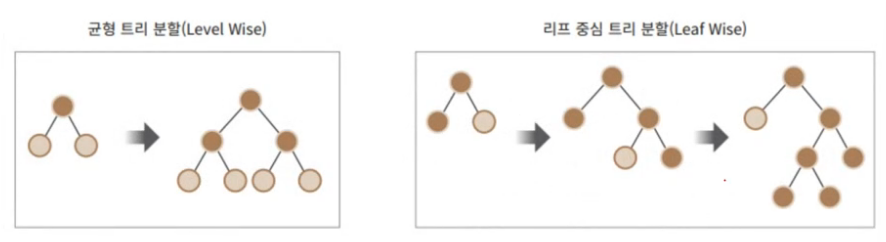<br>
* LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식을 사용
* 균형 트리 분할 : depth를 최소화하기 위한 방식
* 리프 중심 트리 분할 : 예측 오류를 줄여주기 위한 방식

### LightGBM 하이퍼 파라미터<br>
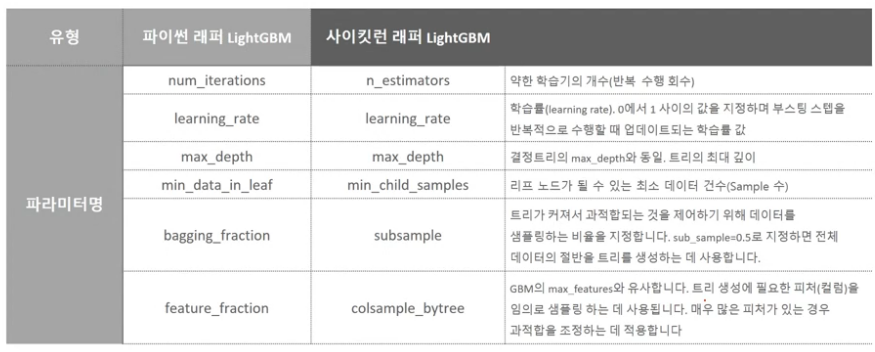<br>
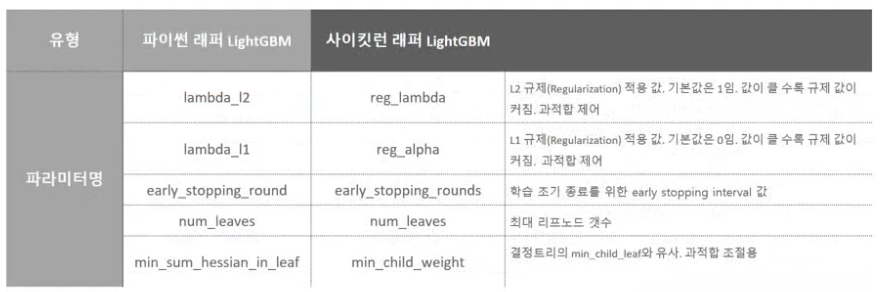<br>
* LightGBM 사이킷런 래퍼는 XGBoost 사이킷런 래퍼에 해당 하이퍼 파라미터가 있으면 이를 그대로 사용하고 그렇지 않으면 파이썬 래퍼 LightGBM 하이퍼 파라미터를 사용
* num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안 (=> 즉, num_leaves가 핵심 하이퍼 파라미터임)

### LightGBM 적용 - 위스콘신 유방암 예측

In [2]:
import lightgbm

print(lightgbm.__version__)

3.3.2


In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier # 사이킷런 wrapper 기준

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size = 0.2, random_state = 156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1, random_state = 156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate = 0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss',
                 eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

=> 101개의 약한 학습기만 사용하고 끝났으므로, 61번째로 가보니 최소 logloss 값을 가지는 것을 확인할 수 있음

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
           F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.9561, 정밀도 : 0.9615, 재현율 : 0.9740,            F1 : 0.9677, AUC : 0.9877


=> 현재 데이터 건수가 작아 성능이 조금 떨어짐

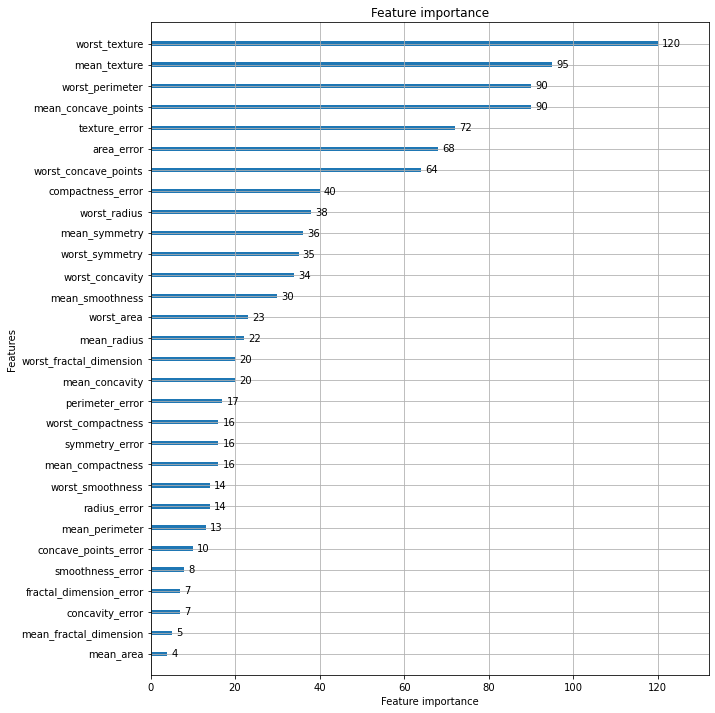

In [6]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm_wrapper, ax = ax)
plt.show()

=> 현재 ndarray가 아닌 DataFrame을 기반으로 알고리즘을 적용했기 때문에 열 이름을 따로 지정해주지 않아도 됨

# 8. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

### 그리드 서치(Grid Search) 기반의 하이퍼 파라미터 튜닝의 문제점
* 하이퍼 파라미터 튜닝 수행 방법
 * Grid Search
 * Random Search : Grid Search를 기반으로 random하게
 * Bayesian Optimization
 * 수동 튜닝
* 하이퍼 파라미터 튜닝의 주요 이슈
 * Gradient Boosting 기반 알고리즘은 튜닝해야 할 하이퍼 파라미터 개수가 많고 범위가 넓어서 가능한 개별 경우의 수가 너무 많음
 * 이러한 경우의 수가 많을 경우 데이터가 크면 하이퍼 파라미터 튜닝에 굉장히 오랜 시간이 투입되어야 함

* GridSearch와 Random Search의 주요 이슈<br>
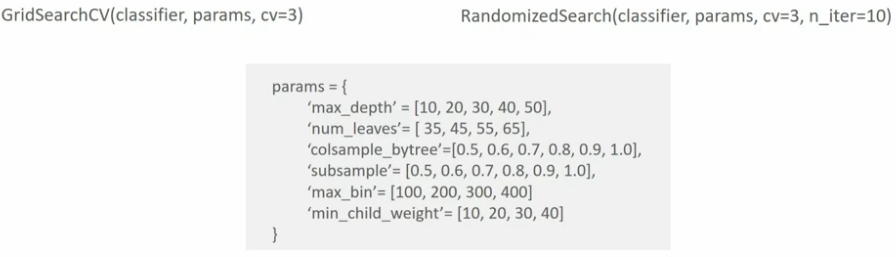<br>
 * GridSearchCV는 수행 시간이 너무 오래 걸림. 개별 하이퍼 파라미터들을 Grid 형태로 지정하는 것은 한계가 존재(데이터 세트가 작을 때 유리)
 * RandomizedSearch는 수행 시간은 줄여주지만, Random한 선택으로 최적 하이퍼 파라미터 검출에 태생적 제약(데이터 세트가 클 때 유리)
 * 두가지 방법 모두 iteration 중에 어느정도 최적화된 하이퍼 파라미터들을 활용하면서 최적화를 수행할 수 없음

* Bayesian 최적화가 필요한 순간
 * 가능한 최소의 시도로 최적의 답을 찾아야 할 경우
 * 개별 시도가 너무 많은 시간/자원이 필요할 때

### 베이지안 최적화 개요
 * 베이지안 최적화는 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
 * 베이지안 최적화는 이름에서 유추해 볼 수 있듯이 베이지안 확률에 기반을 두고 있는 최적화 기법
 * 베이지안 확률이 새로운 사건의 관측이나 새로운 샘플 데이터를 기반으로 사후 확률을 개선해 나가듯이, 베이지안 최적화는 새로운 데이터를 입력받았을 대 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만들어냄
 * 베이지안 최적화를 구성하는 두 가지 중요 요소는 `대체 모델(Surrogate Model)`과 `획득 함수(Acquisition Function)`
 * 대체 모델은 획득 함수로부터 최적 입력 값을 추천 받은 뒤 이를 기반으로 최적 함수 모델을 개선
 * 획득 함수는 개선된 대체 모델을 기반으로 다시 최적 입력 값을 계산<br>
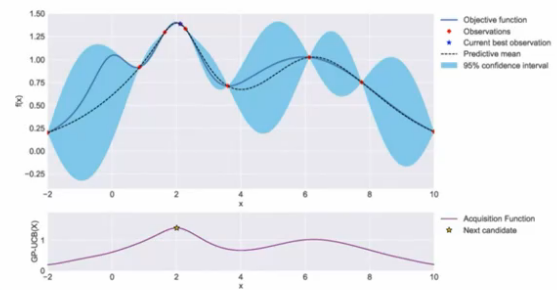

* 베이지안 최적화 수행 단계
 * step1 : 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하여 성능 결과를 관측<br>
 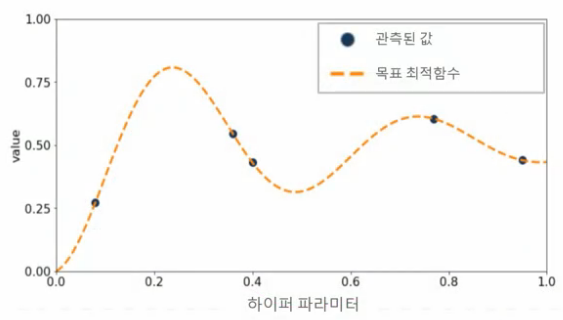<br>
 => 노란색 선이 목표로 하는 최적함수<br>
 * step2 : 관측된 값을 기반으로 대체 모델은 최적 함수를 예측 추정<br>
 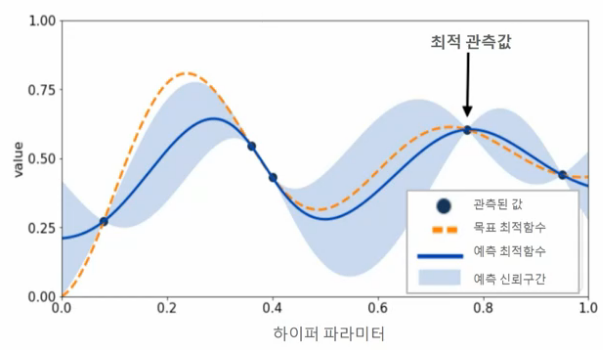<br>
 * step3 : 획득 함수에서 다음으로 관측할 하이퍼 파라미터 추출<br>
 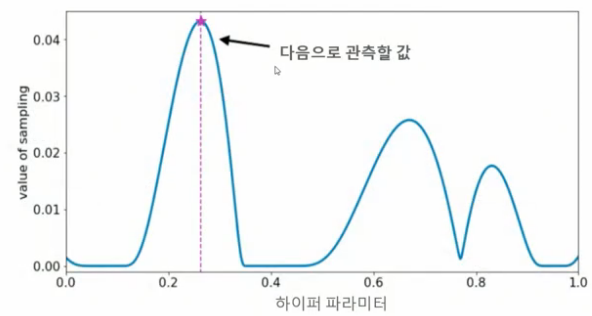<br>
 => 0.27 정도 되는 것으로 판단<br><br>
 * step4 : 해당 하이퍼 파라미터로 관측된 값을 기반으로 대체 모델은 다시 최적 함수를 예측 추정<br>
 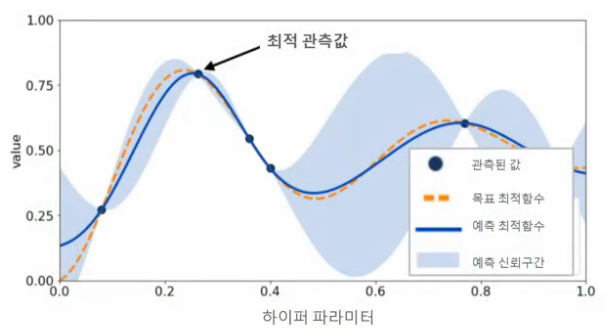<br>
 => 점점 개선이 되면서 목표 최적함수에 예측 최적함수가 가까워지면서 그 때의 최대값이 될 수 있는 하이퍼 파라미터를 반환해주는 방식
 

* 베이지안 최적화 구현 요소
 * 입력값 범위
 * 함수
 * 함수 반환 최대/최소값 유추<br>
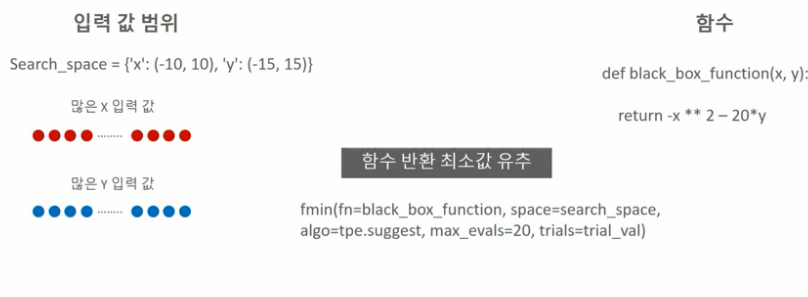

* 베이지안 최적화를 구현한 주요 패키지
 * HyperOpt
 * Bayesian optimization
 * Optuna : 제일 최신에 나온 패키지
* HyperOpt를 통한 최적화 예시<br>
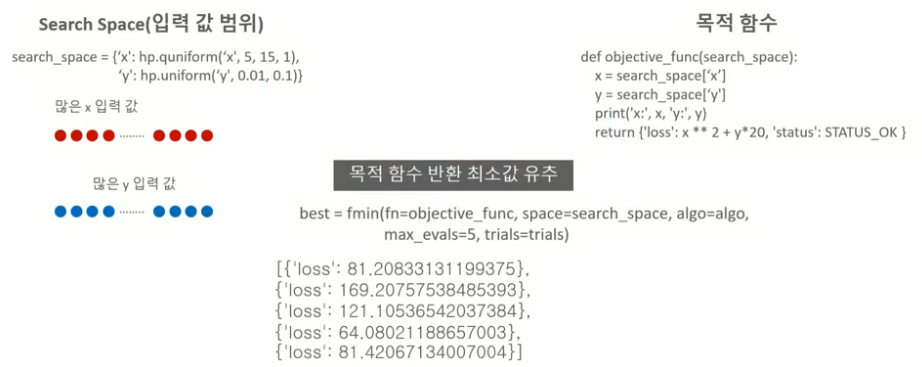<br>

* HyperOpt의 주요 구성 요소
 * 입력값 범위(Search space)
   * 여러 개의 입력 변수들과 이들 값의 범위를 지정
   * hp.quniform(label, low, high, q) : label로 지정된 입력 값 변수 검색 공간을 최소값 low에서 최대값 high까지 q의 간격을 가지고 설정
   * hp.uniform(label, low, high) : 최소값 low에서 최대값 high까지 정규 분포 형태의 검색 공간 설정
   * hp.randint(label, upper) : 0부터 최대값 upper까지 random한 정수 값으로 검색 공간 설정
   * hp.loguniform(label, low, high) : exp(uniform(low, high))값을 반환하며, 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
  * 목적함수
    * search space를 입력 받아 로직에 따라 loss 값을 계산하고 이를 반환하는 함수
    * 반드시 딕셔너리 형태의 값을 반환하고 여기에 'loss':loss 값이 기재되어야 함
  * 목적함수의 최소값을 찾는 함수
    * 목적함수를 실행하여 최소 반환값(loss)를 최적으로 찾아내는 함수
    * Bayesian 최적화 기법으로 입력 변수들의 search space 상에서 정해진 횟수만큼 입력 변수들을 입력하여 목적 함수의 반환값(loss)을 최적으로 찾아냄
    * hyperopt는 이를 위해 fmin() 함수를 제공
    * fmin() 함수의 인자로 목적함수, search space, 베이지안 최적화 기법유형, 최적화 시도횟수, 최적화 로그 기록 객체를 인자로 넣어줌
    * best = fmin(objective, space = hp.uniform('x', -10, 10), algo = tpe.suggest, max_evals = 199, trials = trials)

### HyperOpt 사용하기

In [7]:
import hyperopt

print(hyperopt.__version__)

0.2.7


In [8]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력변수 x 집합값과 - 15 ~ 15까지 1 간격을 가지는 입력변수 y 집합값 설정
search_space = {'x':hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

In [9]:
search_space

{'x': <hyperopt.pyll.base.Apply at 0x2413c26d3d0>,
 'y': <hyperopt.pyll.base.Apply at 0x2413c26da90>}

In [10]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 입력 변수값과 입력 변수 검색 범위를 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y # 원래는 목적함수를 모름. 예제를 들기 위해 설정
    
    return retval

In [11]:
# 보통 베이지안최적화를 수행할 때는 가우시안 최적화를 사용하지만, hyperopt는 tpe라는 클래스를 사용
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결과값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals = 5)로 찾아냄
best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5, # 5번만에 찾아주세요 !
               trials = trial_val, rstate = np.random.default_rng(seed = 0)) # trial_val의 각 수행마다 입력변수와 결과값을 저장, rstate는 기본적으로 빼는 게 수행결과가 더 나음
print('best :', best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 227.87trial/s, best loss: -224.0]
best : {'x': -4.0, 'y': 12.0}


=> x = 0, y = 15가 되어야 최소값이 되지만 비교적 최소가 되는 값을 5번만에 잘 찾았음

In [12]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))
print('best :', best_02) # best_02는 best일 때 파라미터값을 반환, 기존값이 float 형태로 반환

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 334.03trial/s, best loss: -296.0]
best : {'x': 2.0, 'y': 15.0}


=> 20번만에 더 가까운 결과를 잘 찾아주었음

* Hyperopt 수행 시 적용된 입력값들과 목적 함수 반환값 보기
 * trial_val의 중요 결과
   * result : 목적함수 값 반환
   * vals : 입력값 반환

In [13]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'statas':반환 상태값}와 같은 딕셔너리
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [14]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


=> 입력값과 loss 값을 한 번에 확인하기 어려움

In [15]:
import pandas as pd

# results에서 loss 키 값에 해당하는 값들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성
result_df = pd.DataFrame({'x':trial_val.vals['x'],
                          'y':trial_val.vals['y'],
                          'losses':losses})

result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [16]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size = 0.2, random_state = 156)

# 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1, random_state = 156)

In [17]:
from hyperopt import hp

# max_depth는 5에서 20까지 1 간격으로, min_child_weight는 1에서 2까지 1 간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1)}

In [18]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
# 정확도는 높을수록 더 좋은 수치임 -> -1을 정확도에 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 n_estimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric = 'logloss')
    
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)
    
    # accuracy는 cv = 3 개수만큼의 정확도 결과를 가지므로 이를 평균해서 반환하되 -1을 곱해줌
    return {'loss' : -1 * np.mean(accuracy), 'status' : STATUS_OK}

In [19]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn = objective_func, 
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 50, # 최대 반복 횟수를 지정
            trials = trial_val, rstate = np.random.default_rng(seed = 9))
print('best :', best)

100%|███████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62trial/s, best loss: -0.9670616939700244]
best : {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [20]:
print('colsample_bytree : {0}, learning_rate : {1}, max_depth : {2}, min_child_weight : {3}'.format(
                        round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
                        int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree : 0.54241, learning_rate : 0.12601, max_depth : 17, min_child_weight : 2


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
          F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = round(best['learning_rate'], 5),
                            max_depth = int(best['max_depth']), min_child_weight = int(best['min_child_weight']),
                            colsample_bytree = round(best['colsample_bytree'], 5))

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss',
                eval_set = evals, verbose = True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62048
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34224	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30425	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38953
[7]	validation_0-logloss:0.24503	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22050	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19873	validation_1-logloss:0.33798
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32463
[11]	validation_0-logloss:0.16354	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15032	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13813	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29513
[15]	validation_0-logloss:0.11926	validation_1-logloss:0.28891
[1

[130]	validation_0-logloss:0.01639	validation_1-logloss:0.22934
[131]	validation_0-logloss:0.01634	validation_1-logloss:0.22987
[132]	validation_0-logloss:0.01629	validation_1-logloss:0.22927
[133]	validation_0-logloss:0.01624	validation_1-logloss:0.23076
[134]	validation_0-logloss:0.01620	validation_1-logloss:0.23030
[135]	validation_0-logloss:0.01615	validation_1-logloss:0.22891
[136]	validation_0-logloss:0.01610	validation_1-logloss:0.22883
[137]	validation_0-logloss:0.01606	validation_1-logloss:0.22882
[138]	validation_0-logloss:0.01601	validation_1-logloss:0.22876
[139]	validation_0-logloss:0.01597	validation_1-logloss:0.22734
[140]	validation_0-logloss:0.01592	validation_1-logloss:0.22882
[141]	validation_0-logloss:0.01588	validation_1-logloss:0.22935
[142]	validation_0-logloss:0.01583	validation_1-logloss:0.22880
[143]	validation_0-logloss:0.01579	validation_1-logloss:0.22856
[144]	validation_0-logloss:0.01575	validation_1-logloss:0.22725
[145]	validation_0-logloss:0.01571	valid

In [23]:
losses = [loss_dict['loss'] for loss_dict in trial_val.results]
result_df = pd.DataFrame({'max_depth' : trial_val.vals['max_depth'],
                          'min_child_weight' : trial_val.vals['min_child_weight'],
                          'colsample_bytree' : trial_val.vals['colsample_bytree'],
                          'learning_rate' : trial_val.vals['learning_rate'],
                          'losses' : losses})

result_df

,max_depth,min_child_weight,colsample_bytree,learning_rate,losses
0,19.0,2.0,0.585235,0.033688,-0.947296
1,5.0,2.0,0.727186,0.105956,-0.960483
2,6.0,2.0,0.959945,0.154804,-0.958290
3,6.0,2.0,0.950012,0.120686,-0.960468
4,16.0,2.0,0.674336,0.142392,-0.962661
5,8.0,2.0,0.863774,0.106579,-0.958275
6,14.0,2.0,0.957521,0.079111,-0.956097
7,19.0,2.0,0.695018,0.095213,-0.960468
8,9.0,2.0,0.684442,0.147520,-0.962661
9,8.0,1.0,0.592116,0.081179,-0.956097


# 9. 분류 실습 - 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv('./train_santander.csv', encoding = 'latin-1')
print('dataset shape :', cust_df.shape)
cust_df.head(3)

dataset shape : (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


=> TARGET 값은 0이 만족한 고객, 1이 불만족한 고객을 의미

In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


=> column이 너무 많아서 정보가 자세히 나오지는 않음

In [4]:
cust_df[cust_df['TARGET'] == 1].TARGET.shape[0]

3008

In [5]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 : {0:.2f}'.format(unsatisfied_cnt / total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 : 0.04


In [6]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


=> var3의 평균값이 -999999인 것을 의심해보아야 함

In [7]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace = True) # 2 값이 가장 많으므로 2로 대체
cust_df.drop('ID', axis = 1, inplace = True)

# 피처 세트와 레이블 세트 분리, 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 세트 shape : {0}'.format(X_features.shape))

피처 데이터 세트 shape : (76020, 369)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 shape : {0}, 테스트 세트 shape : {1}'.format(X_train.shape, X_test.shape), '\n')
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 shape : (60816, 369), 테스트 세트 shape : (15204, 369) 

학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [9]:
# Early stopping 검증을 위한 데이터셋 분리
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.3, random_state = 0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

* HyperOpt를 이용한 하이퍼 파라미터 튜닝

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate는 0.05, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = 0.05, random_state = 156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = [(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.83092	validation_1-auc:0.80941
[2]	validation_0-auc:0.83207	validation_1-auc:0.80903
[3]	validation_0-auc:0.83288	validation_1-auc:0.80889
[4]	validation_0-auc:0.83414	validation_1-auc:0.80924
[5]	validation_0-auc:0.83524	validation_1-auc:0.80907
[6]	validation_0-auc:0.83568	validation_1-auc:0.81004
[7]	validation_0-auc:0.83741	validation_1-auc:0.81088
[8]	validation_0-auc:0.83896	validation_1-auc:0.81305
[9]	validation_0-auc:0.83949	validation_1-auc:0.81363
[10]	validation_0-auc:0.83908	validation_1-auc:0.81277
[11]	validation_0-auc:0.83913	validation_1-auc:0.81260
[12]	validation_0-auc:0.84009	validation_1-auc:0.81325
[13]	validation_0-auc:0.84081	validation_1-auc:0.81329
[14]	validation_0-auc:0.84196	validation_1-auc:0.81380
[15]	validation_0-auc:0.84394	validation_1-auc:0.81540
[16]	validation_0-auc:0.84414	validation_1-auc:0.81573
[17]	validation_0-auc:0.84437	validation_1-auc:0.81577
[18]	validation_0-au

[149]	validation_0-auc:0.90457	validation_1-auc:0.83346
[150]	validation_0-auc:0.90465	validation_1-auc:0.83343
[151]	validation_0-auc:0.90469	validation_1-auc:0.83344
[152]	validation_0-auc:0.90482	validation_1-auc:0.83342
[153]	validation_0-auc:0.90501	validation_1-auc:0.83339
[154]	validation_0-auc:0.90513	validation_1-auc:0.83336
[155]	validation_0-auc:0.90518	validation_1-auc:0.83334
[156]	validation_0-auc:0.90525	validation_1-auc:0.83331
[157]	validation_0-auc:0.90531	validation_1-auc:0.83339
[158]	validation_0-auc:0.90549	validation_1-auc:0.83330
[159]	validation_0-auc:0.90559	validation_1-auc:0.83331
[160]	validation_0-auc:0.90574	validation_1-auc:0.83342
[161]	validation_0-auc:0.90592	validation_1-auc:0.83339
[162]	validation_0-auc:0.90598	validation_1-auc:0.83340
[163]	validation_0-auc:0.90601	validation_1-auc:0.83340
[164]	validation_0-auc:0.90629	validation_1-auc:0.83337
[165]	validation_0-auc:0.90641	validation_1-auc:0.83333
[166]	validation_0-auc:0.90652	validation_1-auc:

* 하이퍼 파라미터 튜닝을 하였을 때

In [12]:
from hyperopt import hp

# max_depth는 5에서 15까지 1 간격으로, min_child_weight는 1에서 6까지 1 간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색

xgb_search_space = {'max_depth' : hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정
# 추후 fmin()에서 입력된 search_space 값으로 XGBClassifier 교차 검증 학습 후 -1 * roc_auc 평균 값을 반환
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            colsample_bytree = search_space['colsample_bytree'],
                            learning_rate = search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits = 3)
    
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                    eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpet는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

=> 지난 번에는 교차검증으로 cross_val_score를 사용했는데 조기 중단 조건을 사용할 수 없었기 때문에 k-fold를 사용

In [14]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 10, # 최대 반복 횟수 지정, 실행 시간으로 인해 임의로 50 -> 10으로 !
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best :', best)

[0]	validation_0-auc:0.81678	validation_1-auc:0.79160                                                                  
[1]	validation_0-auc:0.82454	validation_1-auc:0.79688                                                                  
[2]	validation_0-auc:0.83323	validation_1-auc:0.80572                                                                  
[3]	validation_0-auc:0.83854	validation_1-auc:0.81095                                                                  
[4]	validation_0-auc:0.83847	validation_1-auc:0.80989                                                                  
[5]	validation_0-auc:0.83879	validation_1-auc:0.80978                                                                  
[6]	validation_0-auc:0.84053	validation_1-auc:0.81042                                                                  
[7]	validation_0-auc:0.84129	validation_1-auc:0.81116                                                                  
[8]	validation_0-auc:0.84224	validation_

[68]	validation_0-auc:0.89250	validation_1-auc:0.83282                                                                 
[69]	validation_0-auc:0.89269	validation_1-auc:0.83292                                                                 
[70]	validation_0-auc:0.89308	validation_1-auc:0.83292                                                                 
[71]	validation_0-auc:0.89361	validation_1-auc:0.83264                                                                 
[72]	validation_0-auc:0.89406	validation_1-auc:0.83256                                                                 
[73]	validation_0-auc:0.89430	validation_1-auc:0.83239                                                                 
[74]	validation_0-auc:0.89457	validation_1-auc:0.83261                                                                 
[75]	validation_0-auc:0.89482	validation_1-auc:0.83233                                                                 
[76]	validation_0-auc:0.89494	validation

[46]	validation_0-auc:0.88228	validation_1-auc:0.83625                                                                 
[47]	validation_0-auc:0.88318	validation_1-auc:0.83603                                                                 
[48]	validation_0-auc:0.88406	validation_1-auc:0.83587                                                                 
[49]	validation_0-auc:0.88499	validation_1-auc:0.83567                                                                 
[50]	validation_0-auc:0.88567	validation_1-auc:0.83621                                                                 
[51]	validation_0-auc:0.88617	validation_1-auc:0.83640                                                                 
[52]	validation_0-auc:0.88688	validation_1-auc:0.83592                                                                 
[53]	validation_0-auc:0.88747	validation_1-auc:0.83641                                                                 
[54]	validation_0-auc:0.88846	validation

[14]	validation_0-auc:0.85451	validation_1-auc:0.82647                                                                 
[15]	validation_0-auc:0.85543	validation_1-auc:0.82596                                                                 
[16]	validation_0-auc:0.85660	validation_1-auc:0.82658                                                                 
[17]	validation_0-auc:0.85740	validation_1-auc:0.82710                                                                 
[18]	validation_0-auc:0.85886	validation_1-auc:0.82679                                                                 
[19]	validation_0-auc:0.85976	validation_1-auc:0.82722                                                                 
[20]	validation_0-auc:0.86042	validation_1-auc:0.82733                                                                 
[21]	validation_0-auc:0.86157	validation_1-auc:0.82861                                                                 
[22]	validation_0-auc:0.86180	validation

[82]	validation_0-auc:0.90020	validation_1-auc:0.83718                                                                 
[83]	validation_0-auc:0.90074	validation_1-auc:0.83709                                                                 
[84]	validation_0-auc:0.90102	validation_1-auc:0.83728                                                                 
[85]	validation_0-auc:0.90138	validation_1-auc:0.83751                                                                 
[86]	validation_0-auc:0.90155	validation_1-auc:0.83765                                                                 
[87]	validation_0-auc:0.90164	validation_1-auc:0.83763                                                                 
[88]	validation_0-auc:0.90170	validation_1-auc:0.83761                                                                 
[89]	validation_0-auc:0.90205	validation_1-auc:0.83762                                                                 
[90]	validation_0-auc:0.90245	validation

[50]	validation_0-auc:0.90266	validation_1-auc:0.83022                                                                 
[51]	validation_0-auc:0.90405	validation_1-auc:0.83032                                                                 
[52]	validation_0-auc:0.90442	validation_1-auc:0.83093                                                                 
[53]	validation_0-auc:0.90522	validation_1-auc:0.82994                                                                 
[54]	validation_0-auc:0.90567	validation_1-auc:0.82977                                                                 
[55]	validation_0-auc:0.90641	validation_1-auc:0.82996                                                                 
[56]	validation_0-auc:0.90675	validation_1-auc:0.82932                                                                 
[57]	validation_0-auc:0.90716	validation_1-auc:0.82900                                                                 
[58]	validation_0-auc:0.90809	validation

[36]	validation_0-auc:0.89003	validation_1-auc:0.82920                                                                 
[37]	validation_0-auc:0.89056	validation_1-auc:0.82864                                                                 
[38]	validation_0-auc:0.89098	validation_1-auc:0.82831                                                                 
[39]	validation_0-auc:0.89170	validation_1-auc:0.82861                                                                 
[40]	validation_0-auc:0.89309	validation_1-auc:0.82975                                                                 
[41]	validation_0-auc:0.89324	validation_1-auc:0.82911                                                                 
[42]	validation_0-auc:0.89552	validation_1-auc:0.82967                                                                 
[43]	validation_0-auc:0.89671	validation_1-auc:0.82997                                                                 
[44]	validation_0-auc:0.89801	validation

[4]	validation_0-auc:0.84851	validation_1-auc:0.81928                                                                  
[5]	validation_0-auc:0.85510	validation_1-auc:0.82100                                                                  
[6]	validation_0-auc:0.85611	validation_1-auc:0.82251                                                                  
[7]	validation_0-auc:0.85814	validation_1-auc:0.82231                                                                  
[8]	validation_0-auc:0.85953	validation_1-auc:0.82212                                                                  
[9]	validation_0-auc:0.86282	validation_1-auc:0.82205                                                                  
[10]	validation_0-auc:0.86284	validation_1-auc:0.82076                                                                 
[11]	validation_0-auc:0.86207	validation_1-auc:0.82028                                                                 
[12]	validation_0-auc:0.86463	validation

[72]	validation_0-auc:0.91843	validation_1-auc:0.83110                                                                 
[73]	validation_0-auc:0.91871	validation_1-auc:0.83085                                                                 
[74]	validation_0-auc:0.91939	validation_1-auc:0.83065                                                                 
[75]	validation_0-auc:0.91973	validation_1-auc:0.83107                                                                 
[76]	validation_0-auc:0.92015	validation_1-auc:0.83147                                                                 
[77]	validation_0-auc:0.92044	validation_1-auc:0.83143                                                                 
[78]	validation_0-auc:0.92071	validation_1-auc:0.83193                                                                 
[79]	validation_0-auc:0.92112	validation_1-auc:0.83232                                                                 
[80]	validation_0-auc:0.92183	validation

[40]	validation_0-auc:0.93490	validation_1-auc:0.82603                                                                 
[41]	validation_0-auc:0.93518	validation_1-auc:0.82577                                                                 
[42]	validation_0-auc:0.93575	validation_1-auc:0.82560                                                                 
[43]	validation_0-auc:0.93603	validation_1-auc:0.82574                                                                 
[44]	validation_0-auc:0.93697	validation_1-auc:0.82628                                                                 
[45]	validation_0-auc:0.93714	validation_1-auc:0.82631                                                                 
[46]	validation_0-auc:0.93740	validation_1-auc:0.82635                                                                 
[47]	validation_0-auc:0.93805	validation_1-auc:0.82599                                                                 
[48]	validation_0-auc:0.93842	validation

[49]	validation_0-auc:0.94047	validation_1-auc:0.83093                                                                 
[50]	validation_0-auc:0.94068	validation_1-auc:0.83113                                                                 
[51]	validation_0-auc:0.94156	validation_1-auc:0.83151                                                                 
[52]	validation_0-auc:0.94219	validation_1-auc:0.83151                                                                 
[53]	validation_0-auc:0.94260	validation_1-auc:0.83139                                                                 
[54]	validation_0-auc:0.94326	validation_1-auc:0.83146                                                                 
[0]	validation_0-auc:0.83493	validation_1-auc:0.81063                                                                  
[1]	validation_0-auc:0.84197	validation_1-auc:0.81316                                                                  
[2]	validation_0-auc:0.85026	validation_

[62]	validation_0-auc:0.94578	validation_1-auc:0.83233                                                                 
[63]	validation_0-auc:0.94587	validation_1-auc:0.83211                                                                 
[64]	validation_0-auc:0.94588	validation_1-auc:0.83213                                                                 
[65]	validation_0-auc:0.94617	validation_1-auc:0.83215                                                                 
[66]	validation_0-auc:0.94637	validation_1-auc:0.83167                                                                 
[67]	validation_0-auc:0.94649	validation_1-auc:0.83147                                                                 
[68]	validation_0-auc:0.94655	validation_1-auc:0.83137                                                                 
[69]	validation_0-auc:0.94663	validation_1-auc:0.83122                                                                 
[70]	validation_0-auc:0.94733	validation

[44]	validation_0-auc:0.89368	validation_1-auc:0.83013                                                                 
[45]	validation_0-auc:0.89462	validation_1-auc:0.83043                                                                 
[46]	validation_0-auc:0.89491	validation_1-auc:0.83080                                                                 
[47]	validation_0-auc:0.89603	validation_1-auc:0.83055                                                                 
[48]	validation_0-auc:0.89664	validation_1-auc:0.83082                                                                 
[49]	validation_0-auc:0.89744	validation_1-auc:0.83093                                                                 
[50]	validation_0-auc:0.89780	validation_1-auc:0.83066                                                                 
[51]	validation_0-auc:0.89840	validation_1-auc:0.83060                                                                 
[52]	validation_0-auc:0.89947	validation

[12]	validation_0-auc:0.85695	validation_1-auc:0.82279                                                                 
[13]	validation_0-auc:0.86039	validation_1-auc:0.82427                                                                 
[14]	validation_0-auc:0.86126	validation_1-auc:0.82481                                                                 
[15]	validation_0-auc:0.86335	validation_1-auc:0.82649                                                                 
[16]	validation_0-auc:0.86505	validation_1-auc:0.82707                                                                 
[17]	validation_0-auc:0.86622	validation_1-auc:0.82740                                                                 
[18]	validation_0-auc:0.86591	validation_1-auc:0.82552                                                                 
[19]	validation_0-auc:0.86830	validation_1-auc:0.82661                                                                 
[20]	validation_0-auc:0.86984	validation

[80]	validation_0-auc:0.91933	validation_1-auc:0.83045                                                                 
[81]	validation_0-auc:0.91976	validation_1-auc:0.83005                                                                 
[82]	validation_0-auc:0.92009	validation_1-auc:0.83046                                                                 
[0]	validation_0-auc:0.83132	validation_1-auc:0.81167                                                                  
[1]	validation_0-auc:0.83662	validation_1-auc:0.81285                                                                  
[2]	validation_0-auc:0.84048	validation_1-auc:0.81616                                                                  
[3]	validation_0-auc:0.84220	validation_1-auc:0.81680                                                                  
[4]	validation_0-auc:0.84545	validation_1-auc:0.81751                                                                  
[5]	validation_0-auc:0.85363	validation_

[65]	validation_0-auc:0.91113	validation_1-auc:0.82687                                                                 
[66]	validation_0-auc:0.91174	validation_1-auc:0.82650                                                                 
[67]	validation_0-auc:0.91210	validation_1-auc:0.82694                                                                 
[68]	validation_0-auc:0.91279	validation_1-auc:0.82720                                                                 
[69]	validation_0-auc:0.91354	validation_1-auc:0.82750                                                                 
[70]	validation_0-auc:0.91416	validation_1-auc:0.82789                                                                 
[71]	validation_0-auc:0.91459	validation_1-auc:0.82784                                                                 
[72]	validation_0-auc:0.91521	validation_1-auc:0.82798                                                                 
[73]	validation_0-auc:0.91593	validation

[47]	validation_0-auc:0.94894	validation_1-auc:0.82298                                                                 
[48]	validation_0-auc:0.94990	validation_1-auc:0.82219                                                                 
[49]	validation_0-auc:0.95038	validation_1-auc:0.82191                                                                 
[50]	validation_0-auc:0.95054	validation_1-auc:0.82184                                                                 
[51]	validation_0-auc:0.95128	validation_1-auc:0.82163                                                                 
[52]	validation_0-auc:0.95158	validation_1-auc:0.82149                                                                 
[53]	validation_0-auc:0.95166	validation_1-auc:0.82083                                                                 
[54]	validation_0-auc:0.95247	validation_1-auc:0.82074                                                                 
[55]	validation_0-auc:0.95252	validation

[3]	validation_0-auc:0.85812	validation_1-auc:0.81956                                                                  
[4]	validation_0-auc:0.86408	validation_1-auc:0.82143                                                                  
[5]	validation_0-auc:0.86731	validation_1-auc:0.82281                                                                  
[6]	validation_0-auc:0.87105	validation_1-auc:0.82461                                                                  
[7]	validation_0-auc:0.87499	validation_1-auc:0.82682                                                                  
[8]	validation_0-auc:0.88082	validation_1-auc:0.82873                                                                  
[9]	validation_0-auc:0.88887	validation_1-auc:0.82957                                                                  
[10]	validation_0-auc:0.89139	validation_1-auc:0.82678                                                                 
[11]	validation_0-auc:0.89241	validation

[71]	validation_0-auc:0.95859	validation_1-auc:0.82819                                                                 
[72]	validation_0-auc:0.95870	validation_1-auc:0.82823                                                                 
[0]	validation_0-auc:0.82360	validation_1-auc:0.80052                                                                  
[1]	validation_0-auc:0.82942	validation_1-auc:0.80498                                                                  
[2]	validation_0-auc:0.83477	validation_1-auc:0.80715                                                                  
[3]	validation_0-auc:0.83989	validation_1-auc:0.81232                                                                  
[4]	validation_0-auc:0.84115	validation_1-auc:0.81348                                                                  
[5]	validation_0-auc:0.84452	validation_1-auc:0.81346                                                                  
[6]	validation_0-auc:0.84443	validation_

[66]	validation_0-auc:0.90008	validation_1-auc:0.83154                                                                 
[67]	validation_0-auc:0.90020	validation_1-auc:0.83153                                                                 
[68]	validation_0-auc:0.90036	validation_1-auc:0.83136                                                                 
[69]	validation_0-auc:0.90048	validation_1-auc:0.83120                                                                 
[70]	validation_0-auc:0.90067	validation_1-auc:0.83097                                                                 
[71]	validation_0-auc:0.90076	validation_1-auc:0.83103                                                                 
[72]	validation_0-auc:0.90084	validation_1-auc:0.83093                                                                 
[73]	validation_0-auc:0.90118	validation_1-auc:0.83070                                                                 
[74]	validation_0-auc:0.90127	validation

[54]	validation_0-auc:0.89612	validation_1-auc:0.83679                                                                 
[55]	validation_0-auc:0.89659	validation_1-auc:0.83662                                                                 
[56]	validation_0-auc:0.89672	validation_1-auc:0.83663                                                                 
[57]	validation_0-auc:0.89782	validation_1-auc:0.83644                                                                 
[58]	validation_0-auc:0.89819	validation_1-auc:0.83676                                                                 
[59]	validation_0-auc:0.89874	validation_1-auc:0.83668                                                                 
[60]	validation_0-auc:0.89903	validation_1-auc:0.83703                                                                 
[61]	validation_0-auc:0.89949	validation_1-auc:0.83693                                                                 
[62]	validation_0-auc:0.89969	validation

[32]	validation_0-auc:0.88112	validation_1-auc:0.83344                                                                 
[33]	validation_0-auc:0.88175	validation_1-auc:0.83352                                                                 
[34]	validation_0-auc:0.88221	validation_1-auc:0.83393                                                                 
[35]	validation_0-auc:0.88276	validation_1-auc:0.83483                                                                 
[36]	validation_0-auc:0.88370	validation_1-auc:0.83404                                                                 
[37]	validation_0-auc:0.88449	validation_1-auc:0.83298                                                                 
[38]	validation_0-auc:0.88524	validation_1-auc:0.83292                                                                 
[39]	validation_0-auc:0.88642	validation_1-auc:0.83380                                                                 
[40]	validation_0-auc:0.88757	validation

[0]	validation_0-auc:0.82382	validation_1-auc:0.80098                                                                  
[1]	validation_0-auc:0.83035	validation_1-auc:0.80555                                                                  
[2]	validation_0-auc:0.83743	validation_1-auc:0.80962                                                                  
[3]	validation_0-auc:0.84180	validation_1-auc:0.81318                                                                  
[4]	validation_0-auc:0.84380	validation_1-auc:0.81329                                                                  
[5]	validation_0-auc:0.84851	validation_1-auc:0.81871                                                                  
[6]	validation_0-auc:0.84902	validation_1-auc:0.82071                                                                  
[7]	validation_0-auc:0.85059	validation_1-auc:0.82073                                                                  
[8]	validation_0-auc:0.85241	validation_

[68]	validation_0-auc:0.90600	validation_1-auc:0.83078                                                                 
[69]	validation_0-auc:0.90619	validation_1-auc:0.83042                                                                 
[70]	validation_0-auc:0.90650	validation_1-auc:0.83019                                                                 
[71]	validation_0-auc:0.90680	validation_1-auc:0.82995                                                                 
[72]	validation_0-auc:0.90706	validation_1-auc:0.83011                                                                 
[73]	validation_0-auc:0.90719	validation_1-auc:0.83011                                                                 
[74]	validation_0-auc:0.90728	validation_1-auc:0.82986                                                                 
[75]	validation_0-auc:0.90785	validation_1-auc:0.82980                                                                 
[76]	validation_0-auc:0.90803	validation

[55]	validation_0-auc:0.90371	validation_1-auc:0.83843                                                                 
[56]	validation_0-auc:0.90389	validation_1-auc:0.83862                                                                 
[57]	validation_0-auc:0.90487	validation_1-auc:0.83861                                                                 
[58]	validation_0-auc:0.90542	validation_1-auc:0.83840                                                                 
[59]	validation_0-auc:0.90570	validation_1-auc:0.83853                                                                 
[60]	validation_0-auc:0.90596	validation_1-auc:0.83851                                                                 
[61]	validation_0-auc:0.90632	validation_1-auc:0.83839                                                                 
[62]	validation_0-auc:0.90677	validation_1-auc:0.83827                                                                 
[63]	validation_0-auc:0.90685	validation

[36]	validation_0-auc:0.89227	validation_1-auc:0.83339                                                                 
[37]	validation_0-auc:0.89332	validation_1-auc:0.83296                                                                 
[38]	validation_0-auc:0.89416	validation_1-auc:0.83307                                                                 
[39]	validation_0-auc:0.89455	validation_1-auc:0.83377                                                                 
[40]	validation_0-auc:0.89508	validation_1-auc:0.83410                                                                 
[41]	validation_0-auc:0.89605	validation_1-auc:0.83380                                                                 
[42]	validation_0-auc:0.89664	validation_1-auc:0.83407                                                                 
[43]	validation_0-auc:0.89736	validation_1-auc:0.83460                                                                 
[44]	validation_0-auc:0.89794	validation

[16]	validation_0-auc:0.87877	validation_1-auc:0.82191                                                                 
[17]	validation_0-auc:0.88062	validation_1-auc:0.82415                                                                 
[18]	validation_0-auc:0.88113	validation_1-auc:0.82245                                                                 
[19]	validation_0-auc:0.88332	validation_1-auc:0.82334                                                                 
[20]	validation_0-auc:0.88573	validation_1-auc:0.82505                                                                 
[21]	validation_0-auc:0.88681	validation_1-auc:0.82486                                                                 
[22]	validation_0-auc:0.88876	validation_1-auc:0.82493                                                                 
[23]	validation_0-auc:0.89089	validation_1-auc:0.82591                                                                 
[24]	validation_0-auc:0.89300	validation

[0]	validation_0-auc:0.82501	validation_1-auc:0.80482                                                                  
[1]	validation_0-auc:0.82829	validation_1-auc:0.80807                                                                  
[2]	validation_0-auc:0.83970	validation_1-auc:0.82030                                                                  
[3]	validation_0-auc:0.84190	validation_1-auc:0.81994                                                                  
[4]	validation_0-auc:0.84854	validation_1-auc:0.81987                                                                  
[5]	validation_0-auc:0.85006	validation_1-auc:0.82088                                                                  
[6]	validation_0-auc:0.85222	validation_1-auc:0.82112                                                                  
[7]	validation_0-auc:0.85523	validation_1-auc:0.82275                                                                  
[8]	validation_0-auc:0.85818	validation_

[68]	validation_0-auc:0.93614	validation_1-auc:0.83149                                                                 
[69]	validation_0-auc:0.93655	validation_1-auc:0.83172                                                                 
[70]	validation_0-auc:0.93705	validation_1-auc:0.83178                                                                 
[71]	validation_0-auc:0.93771	validation_1-auc:0.83118                                                                 
[72]	validation_0-auc:0.93808	validation_1-auc:0.83156                                                                 
[73]	validation_0-auc:0.93892	validation_1-auc:0.83138                                                                 
[74]	validation_0-auc:0.93926	validation_1-auc:0.83160                                                                 
[0]	validation_0-auc:0.83124	validation_1-auc:0.81038                                                                  
[1]	validation_0-auc:0.83818	validation_

[61]	validation_0-auc:0.93258	validation_1-auc:0.82813                                                                 
[62]	validation_0-auc:0.93318	validation_1-auc:0.82783                                                                 
[63]	validation_0-auc:0.93384	validation_1-auc:0.82766                                                                 
[64]	validation_0-auc:0.93428	validation_1-auc:0.82757                                                                 
[65]	validation_0-auc:0.93469	validation_1-auc:0.82757                                                                 
[66]	validation_0-auc:0.93521	validation_1-auc:0.82748                                                                 
[67]	validation_0-auc:0.93563	validation_1-auc:0.82762                                                                 
[0]	validation_0-auc:0.81859	validation_1-auc:0.79401                                                                  
[1]	validation_0-auc:0.82667	validation_

[61]	validation_0-auc:0.89596	validation_1-auc:0.83121                                                                 
[62]	validation_0-auc:0.89613	validation_1-auc:0.83102                                                                 
[63]	validation_0-auc:0.89634	validation_1-auc:0.83089                                                                 
[64]	validation_0-auc:0.89711	validation_1-auc:0.83084                                                                 
[65]	validation_0-auc:0.89742	validation_1-auc:0.83075                                                                 
[66]	validation_0-auc:0.89779	validation_1-auc:0.83091                                                                 
[67]	validation_0-auc:0.89852	validation_1-auc:0.83059                                                                 
[68]	validation_0-auc:0.89891	validation_1-auc:0.83071                                                                 
[69]	validation_0-auc:0.89908	validation

[54]	validation_0-auc:0.89495	validation_1-auc:0.83775                                                                 
[55]	validation_0-auc:0.89547	validation_1-auc:0.83766                                                                 
[56]	validation_0-auc:0.89562	validation_1-auc:0.83760                                                                 
[57]	validation_0-auc:0.89575	validation_1-auc:0.83758                                                                 
[58]	validation_0-auc:0.89625	validation_1-auc:0.83752                                                                 
[59]	validation_0-auc:0.89650	validation_1-auc:0.83735                                                                 
[60]	validation_0-auc:0.89681	validation_1-auc:0.83733                                                                 
[61]	validation_0-auc:0.89717	validation_1-auc:0.83723                                                                 
[62]	validation_0-auc:0.89745	validation

[37]	validation_0-auc:0.88747	validation_1-auc:0.83628                                                                 
[38]	validation_0-auc:0.88857	validation_1-auc:0.83654                                                                 
[39]	validation_0-auc:0.88890	validation_1-auc:0.83659                                                                 
[40]	validation_0-auc:0.88931	validation_1-auc:0.83679                                                                 
[41]	validation_0-auc:0.89042	validation_1-auc:0.83666                                                                 
[42]	validation_0-auc:0.89080	validation_1-auc:0.83690                                                                 
[43]	validation_0-auc:0.89130	validation_1-auc:0.83702                                                                 
[44]	validation_0-auc:0.89158	validation_1-auc:0.83713                                                                 
[45]	validation_0-auc:0.89193	validation

[28]	validation_0-auc:0.93284	validation_1-auc:0.82648                                                                 
[29]	validation_0-auc:0.93483	validation_1-auc:0.82646                                                                 
[30]	validation_0-auc:0.93646	validation_1-auc:0.82704                                                                 
[31]	validation_0-auc:0.93763	validation_1-auc:0.82709                                                                 
[32]	validation_0-auc:0.93931	validation_1-auc:0.82669                                                                 
[33]	validation_0-auc:0.94040	validation_1-auc:0.82653                                                                 
[34]	validation_0-auc:0.94183	validation_1-auc:0.82578                                                                 
[35]	validation_0-auc:0.94259	validation_1-auc:0.82556                                                                 
[36]	validation_0-auc:0.94350	validation

[34]	validation_0-auc:0.94537	validation_1-auc:0.82935                                                                 
[35]	validation_0-auc:0.94594	validation_1-auc:0.82961                                                                 
[36]	validation_0-auc:0.94696	validation_1-auc:0.82966                                                                 
[37]	validation_0-auc:0.94770	validation_1-auc:0.82970                                                                 
[38]	validation_0-auc:0.94860	validation_1-auc:0.82976                                                                 
[39]	validation_0-auc:0.94885	validation_1-auc:0.83000                                                                 
[40]	validation_0-auc:0.94912	validation_1-auc:0.83029                                                                 
[41]	validation_0-auc:0.94989	validation_1-auc:0.82984                                                                 
[42]	validation_0-auc:0.95007	validation

=> (추측) 3번의 교차검증과 하이퍼 파라미터 최대 반복 횟수 10번이 product된 30번이 실행되고, 각 파라미터에서 3번의 교차검증으로 얻어진 auc score를 평균 내어 return함

In [15]:
# n_estimators를 500으로 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf = XGBClassifier(n_estimators = 500, learning_rate = round(best['learning_rate'], 5),
                        max_depth = int(best['max_depth']), min_child_weight = int(best['min_child_weight']),
                        colsample_bytree = round(best['colsample_bytree'], 5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds = 100,
           eval_metric = 'auc', eval_set = [(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82148	validation_1-auc:0.80768
[1]	validation_0-auc:0.83037	validation_1-auc:0.80964
[2]	validation_0-auc:0.83376	validation_1-auc:0.81063
[3]	validation_0-auc:0.83600	validation_1-auc:0.81105
[4]	validation_0-auc:0.83530	validation_1-auc:0.81046
[5]	validation_0-auc:0.83812	validation_1-auc:0.81185
[6]	validation_0-auc:0.83869	validation_1-auc:0.81144
[7]	validation_0-auc:0.84231	validation_1-auc:0.81423
[8]	validation_0-auc:0.84334	validation_1-auc:0.81393
[9]	validation_0-auc:0.84849	validation_1-auc:0.81820
[10]	validation_0-auc:0.84772	validation_1-auc:0.81669
[11]	validation_0-auc:0.84749	validation_1-auc:0.81579
[12]	validation_0-auc:0.84960	validation_1-auc:0.81675
[13]	validation_0-auc:0.85230	validation_1-auc:0.81834
[14]	validation_0-auc:0.85498	validation_1-auc:0.82075
[15]	validation_0-auc:0.85582	validation_1-auc:0.82076
[16]	validation_0-auc:0.85704	validation_1-auc:0.82095
[17]	validation_0-auc:0.85912	validation_1-auc:0.82172
[18]	validation_0-au

[149]	validation_0-auc:0.91092	validation_1-auc:0.83447
[150]	validation_0-auc:0.91100	validation_1-auc:0.83432
[151]	validation_0-auc:0.91131	validation_1-auc:0.83444
[152]	validation_0-auc:0.91142	validation_1-auc:0.83434
[153]	validation_0-auc:0.91156	validation_1-auc:0.83427
[154]	validation_0-auc:0.91168	validation_1-auc:0.83427
[155]	validation_0-auc:0.91210	validation_1-auc:0.83413
[156]	validation_0-auc:0.91266	validation_1-auc:0.83430
[157]	validation_0-auc:0.91307	validation_1-auc:0.83418
[158]	validation_0-auc:0.91319	validation_1-auc:0.83405
[159]	validation_0-auc:0.91331	validation_1-auc:0.83400
[160]	validation_0-auc:0.91357	validation_1-auc:0.83402
[161]	validation_0-auc:0.91369	validation_1-auc:0.83396
[162]	validation_0-auc:0.91396	validation_1-auc:0.83392
[163]	validation_0-auc:0.91424	validation_1-auc:0.83382
[164]	validation_0-auc:0.91434	validation_1-auc:0.83377
[165]	validation_0-auc:0.91436	validation_1-auc:0.83379
[166]	validation_0-auc:0.91447	validation_1-auc:

=> 하이퍼 파라미터 튜닝을 하지 않았을 때보다 성능이 향상된 것을 확인할 수 있음

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

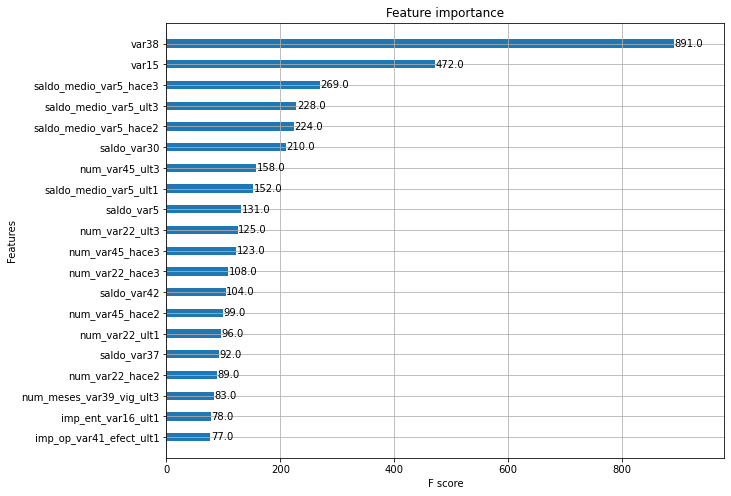

In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

* 하이퍼 파라미터 튜닝을 하지 않았을 때

In [17]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

[75]	training's auc: 0.928639	training's binary_logloss: 0.104167	valid_1's auc: 0.83094	valid_1's binary_logloss: 0.135819
[76]	training's auc: 0.928812	training's binary_logloss: 0.104032	valid_1's auc: 0.831078	valid_1's binary_logloss: 0.135819
[77]	training's auc: 0.929094	training's binary_logloss: 0.103841	valid_1's auc: 0.831173	valid_1's binary_logloss: 0.135831
[78]	training's auc: 0.929304	training's binary_logloss: 0.103661	valid_1's auc: 0.831108	valid_1's binary_logloss: 0.135854
[79]	training's auc: 0.929558	training's binary_logloss: 0.103444	valid_1's auc: 0.830932	valid_1's binary_logloss: 0.135942
[80]	training's auc: 0.930062	training's binary_logloss: 0.103185	valid_1's auc: 0.831212	valid_1's binary_logloss: 0.135846
[81]	training's auc: 0.93021	training's binary_logloss: 0.103035	valid_1's auc: 0.831221	valid_1's binary_logloss: 0.13587
[82]	training's auc: 0.930873	training's binary_logloss: 0.102757	valid_1's auc: 0.831112	valid_1's binary_logloss: 0.135917
[83

ROC AUC : 0.8384


* 하이퍼 파라미터 튜닝을 하였을 때

In [19]:
lgbm_search_space = {'num_leaves' : hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth' : hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples' : hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample' : hp.uniform('subsample', 0.7, 1),
                     'learning_rate' : hp.uniform('learning_rate', 0.01, 0.2)}

In [20]:
def objective_func(search_space):
    lgbm_clf = LGBMClassifier(n_estimators = 100, num_leaves = int(search_space['num_leaves']),
                              max_depth = int(search_space['max_depth']),
                              min_child_samples = int(search_space['min_child_samples']),
                              subsample = search_space['subsample'],
                              learning_rate = search_space['learning_rate'])
    
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 리스트
    roc_auc_list = []
    
    # 3개 k-fold 방식 적용
    kf = KFold(n_splits = 3)
    # X_train을 다시 학습과 검증 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 30, eval_metric = 'auc',
                     eval_set = [(X_tr, y_tr), (X_val, y_val)])
        
        # 1로 예측한 확률값 추출 후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개의 k-fold로 계산된 roc_auc 값의 평균값을 반환하되,
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환
    return -1 * np.mean(roc_auc_list)

In [22]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin() 함수를 호출. max_evals 지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출
best = fmin(fn = objective_func, space = lgbm_search_space, algo = tpe.suggest,
            max_evals  = 10, # 최대 반복 횟수를 지정, 수행 시간으로 인해 50 -> 10으로 줄임
            trials = trials, rstate = np.random.default_rng(seed = 30))

print('best :', best)

[1]	training's auc: 0.82736	training's binary_logloss: 0.162294	valid_1's auc: 0.804818	valid_1's binary_logloss: 0.163544
[2]	training's auc: 0.828309	training's binary_logloss: 0.160269	valid_1's auc: 0.804585	valid_1's binary_logloss: 0.161866
[3]	training's auc: 0.833368	training's binary_logloss: 0.158478	valid_1's auc: 0.806871	valid_1's binary_logloss: 0.16038
[4]	training's auc: 0.834671	training's binary_logloss: 0.156852	valid_1's auc: 0.80706	valid_1's binary_logloss: 0.159053
[5]	training's auc: 0.837783	training's binary_logloss: 0.155354	valid_1's auc: 0.811645	valid_1's binary_logloss: 0.157793
[6]	training's auc: 0.839052	training's binary_logloss: 0.153966	valid_1's auc: 0.81271	valid_1's binary_logloss: 0.156635
[7]	training's auc: 0.841216	training's binary_logloss: 0.152691	valid_1's auc: 0.815103	valid_1's binary_logloss: 0.155585
[8]	training's auc: 0.841859	training's binary_logloss: 0.151499	valid_1's auc: 0.814773	valid_1's binary_logloss: 0.154617
[9]	training

[66]	training's auc: 0.876244	training's binary_logloss: 0.126639	valid_1's auc: 0.829919	valid_1's binary_logloss: 0.137223
[67]	training's auc: 0.876733	training's binary_logloss: 0.126457	valid_1's auc: 0.829943	valid_1's binary_logloss: 0.137148
[68]	training's auc: 0.877004	training's binary_logloss: 0.126282	valid_1's auc: 0.829954	valid_1's binary_logloss: 0.137083
[69]	training's auc: 0.87756	training's binary_logloss: 0.1261	valid_1's auc: 0.830128	valid_1's binary_logloss: 0.137018
[70]	training's auc: 0.87797	training's binary_logloss: 0.12593	valid_1's auc: 0.830009	valid_1's binary_logloss: 0.136959
[71]	training's auc: 0.878271	training's binary_logloss: 0.125757	valid_1's auc: 0.83006	valid_1's binary_logloss: 0.136874
[72]	training's auc: 0.878636	training's binary_logloss: 0.125587	valid_1's auc: 0.830076	valid_1's binary_logloss: 0.136826
[73]	training's auc: 0.879184	training's binary_logloss: 0.125399	valid_1's auc: 0.830085	valid_1's binary_logloss: 0.136789
[74]	t

[31]	training's auc: 0.860346	training's binary_logloss: 0.138259	valid_1's auc: 0.835652	valid_1's binary_logloss: 0.137767
[32]	training's auc: 0.860623	training's binary_logloss: 0.137851	valid_1's auc: 0.835706	valid_1's binary_logloss: 0.137481
[33]	training's auc: 0.861233	training's binary_logloss: 0.137451	valid_1's auc: 0.835552	valid_1's binary_logloss: 0.137215
[34]	training's auc: 0.861685	training's binary_logloss: 0.137067	valid_1's auc: 0.835533	valid_1's binary_logloss: 0.136967
[35]	training's auc: 0.862184	training's binary_logloss: 0.136698	valid_1's auc: 0.835406	valid_1's binary_logloss: 0.136728
[36]	training's auc: 0.862667	training's binary_logloss: 0.136338	valid_1's auc: 0.835312	valid_1's binary_logloss: 0.136482
[37]	training's auc: 0.862991	training's binary_logloss: 0.135983	valid_1's auc: 0.835197	valid_1's binary_logloss: 0.136257
[38]	training's auc: 0.863528	training's binary_logloss: 0.135648	valid_1's auc: 0.835072	valid_1's binary_logloss: 0.136031


[34]	training's auc: 0.858306	training's binary_logloss: 0.13423	valid_1's auc: 0.831793	valid_1's binary_logloss: 0.143018
[35]	training's auc: 0.858929	training's binary_logloss: 0.133883	valid_1's auc: 0.831932	valid_1's binary_logloss: 0.142746
[36]	training's auc: 0.859609	training's binary_logloss: 0.133542	valid_1's auc: 0.832139	valid_1's binary_logloss: 0.142495
[37]	training's auc: 0.860114	training's binary_logloss: 0.133199	valid_1's auc: 0.832296	valid_1's binary_logloss: 0.142265
[38]	training's auc: 0.860777	training's binary_logloss: 0.132855	valid_1's auc: 0.832378	valid_1's binary_logloss: 0.142016
[39]	training's auc: 0.861056	training's binary_logloss: 0.132533	valid_1's auc: 0.832541	valid_1's binary_logloss: 0.141797
[40]	training's auc: 0.861747	training's binary_logloss: 0.132224	valid_1's auc: 0.832606	valid_1's binary_logloss: 0.141578
[41]	training's auc: 0.862158	training's binary_logloss: 0.131929	valid_1's auc: 0.832747	valid_1's binary_logloss: 0.141381
[

[99]	training's auc: 0.885685	training's binary_logloss: 0.121466	valid_1's auc: 0.837478	valid_1's binary_logloss: 0.136439
[100]	training's auc: 0.886052	training's binary_logloss: 0.121345	valid_1's auc: 0.837486	valid_1's binary_logloss: 0.136434
[1]	training's auc: 0.840138	training's binary_logloss: 0.15221	valid_1's auc: 0.812785	valid_1's binary_logloss: 0.155558
[2]	training's auc: 0.84777	training's binary_logloss: 0.145745	valid_1's auc: 0.815828	valid_1's binary_logloss: 0.150616
[3]	training's auc: 0.857571	training's binary_logloss: 0.141216	valid_1's auc: 0.821962	valid_1's binary_logloss: 0.147259
[4]	training's auc: 0.861358	training's binary_logloss: 0.137643	valid_1's auc: 0.824181	valid_1's binary_logloss: 0.144869
[5]	training's auc: 0.866559	training's binary_logloss: 0.134811	valid_1's auc: 0.825962	valid_1's binary_logloss: 0.14308
[6]	training's auc: 0.869278	training's binary_logloss: 0.132436	valid_1's auc: 0.827506	valid_1's binary_logloss: 0.141548
[7]	trai

[26]	training's auc: 0.912142	training's binary_logloss: 0.113763	valid_1's auc: 0.834075	valid_1's binary_logloss: 0.131343
[27]	training's auc: 0.913719	training's binary_logloss: 0.113067	valid_1's auc: 0.833813	valid_1's binary_logloss: 0.131392
[28]	training's auc: 0.915337	training's binary_logloss: 0.112479	valid_1's auc: 0.83399	valid_1's binary_logloss: 0.131391
[29]	training's auc: 0.917253	training's binary_logloss: 0.11188	valid_1's auc: 0.833599	valid_1's binary_logloss: 0.131448
[30]	training's auc: 0.918443	training's binary_logloss: 0.111286	valid_1's auc: 0.833538	valid_1's binary_logloss: 0.131427
[31]	training's auc: 0.919457	training's binary_logloss: 0.110746	valid_1's auc: 0.833293	valid_1's binary_logloss: 0.131479
[32]	training's auc: 0.920976	training's binary_logloss: 0.110085	valid_1's auc: 0.833202	valid_1's binary_logloss: 0.131461
[33]	training's auc: 0.922191	training's binary_logloss: 0.109456	valid_1's auc: 0.83292	valid_1's binary_logloss: 0.13157
[34]

[5]	training's auc: 0.855483	training's binary_logloss: 0.145139	valid_1's auc: 0.820538	valid_1's binary_logloss: 0.149919
[6]	training's auc: 0.856827	training's binary_logloss: 0.14298	valid_1's auc: 0.821063	valid_1's binary_logloss: 0.148333
[7]	training's auc: 0.858639	training's binary_logloss: 0.14107	valid_1's auc: 0.821902	valid_1's binary_logloss: 0.146983
[8]	training's auc: 0.859908	training's binary_logloss: 0.139361	valid_1's auc: 0.822497	valid_1's binary_logloss: 0.145726
[9]	training's auc: 0.863745	training's binary_logloss: 0.137787	valid_1's auc: 0.824282	valid_1's binary_logloss: 0.14463
[10]	training's auc: 0.864538	training's binary_logloss: 0.136428	valid_1's auc: 0.825618	valid_1's binary_logloss: 0.143613
[11]	training's auc: 0.866724	training's binary_logloss: 0.135202	valid_1's auc: 0.826482	valid_1's binary_logloss: 0.142771
[12]	training's auc: 0.867727	training's binary_logloss: 0.134076	valid_1's auc: 0.826391	valid_1's binary_logloss: 0.142056
[13]	tra

[19]	training's auc: 0.876474	training's binary_logloss: 0.130177	valid_1's auc: 0.836385	valid_1's binary_logloss: 0.133702
[20]	training's auc: 0.8775	training's binary_logloss: 0.129479	valid_1's auc: 0.836202	valid_1's binary_logloss: 0.133362
[21]	training's auc: 0.878491	training's binary_logloss: 0.128823	valid_1's auc: 0.835944	valid_1's binary_logloss: 0.133095
[22]	training's auc: 0.879727	training's binary_logloss: 0.128171	valid_1's auc: 0.835803	valid_1's binary_logloss: 0.132857
[23]	training's auc: 0.880833	training's binary_logloss: 0.127616	valid_1's auc: 0.835788	valid_1's binary_logloss: 0.132656
[24]	training's auc: 0.881877	training's binary_logloss: 0.127021	valid_1's auc: 0.836304	valid_1's binary_logloss: 0.132396
[25]	training's auc: 0.882678	training's binary_logloss: 0.126477	valid_1's auc: 0.835986	valid_1's binary_logloss: 0.132262
[26]	training's auc: 0.883555	training's binary_logloss: 0.125961	valid_1's auc: 0.835858	valid_1's binary_logloss: 0.13208
[27

[7]	training's auc: 0.856989	training's binary_logloss: 0.140392	valid_1's auc: 0.828256	valid_1's binary_logloss: 0.148457
[8]	training's auc: 0.859909	training's binary_logloss: 0.138736	valid_1's auc: 0.828911	valid_1's binary_logloss: 0.14717
[9]	training's auc: 0.860832	training's binary_logloss: 0.137248	valid_1's auc: 0.828917	valid_1's binary_logloss: 0.146114
[10]	training's auc: 0.862409	training's binary_logloss: 0.135939	valid_1's auc: 0.829175	valid_1's binary_logloss: 0.145124
[11]	training's auc: 0.863555	training's binary_logloss: 0.134642	valid_1's auc: 0.829481	valid_1's binary_logloss: 0.144268
[12]	training's auc: 0.864843	training's binary_logloss: 0.133431	valid_1's auc: 0.829963	valid_1's binary_logloss: 0.143463
[13]	training's auc: 0.866107	training's binary_logloss: 0.13233	valid_1's auc: 0.830554	valid_1's binary_logloss: 0.142752
[14]	training's auc: 0.868249	training's binary_logloss: 0.131313	valid_1's auc: 0.830759	valid_1's binary_logloss: 0.14214
[15]	t

[5]	training's auc: 0.863741	training's binary_logloss: 0.137779	valid_1's auc: 0.824119	valid_1's binary_logloss: 0.145182
[6]	training's auc: 0.867855	training's binary_logloss: 0.135354	valid_1's auc: 0.824776	valid_1's binary_logloss: 0.143786
[7]	training's auc: 0.871623	training's binary_logloss: 0.13321	valid_1's auc: 0.826166	valid_1's binary_logloss: 0.14244
[8]	training's auc: 0.873921	training's binary_logloss: 0.131346	valid_1's auc: 0.827566	valid_1's binary_logloss: 0.141253
[9]	training's auc: 0.876897	training's binary_logloss: 0.129658	valid_1's auc: 0.828699	valid_1's binary_logloss: 0.140338
[10]	training's auc: 0.881018	training's binary_logloss: 0.128185	valid_1's auc: 0.828684	valid_1's binary_logloss: 0.139621
[11]	training's auc: 0.883713	training's binary_logloss: 0.126777	valid_1's auc: 0.829464	valid_1's binary_logloss: 0.138944
[12]	training's auc: 0.885586	training's binary_logloss: 0.125579	valid_1's auc: 0.829263	valid_1's binary_logloss: 0.138435
[13]	tr

[25]	training's auc: 0.907057	training's binary_logloss: 0.116193	valid_1's auc: 0.834743	valid_1's binary_logloss: 0.13117
[26]	training's auc: 0.908271	training's binary_logloss: 0.115576	valid_1's auc: 0.83419	valid_1's binary_logloss: 0.131239
[27]	training's auc: 0.910741	training's binary_logloss: 0.114927	valid_1's auc: 0.833715	valid_1's binary_logloss: 0.131226
[28]	training's auc: 0.912008	training's binary_logloss: 0.114368	valid_1's auc: 0.834214	valid_1's binary_logloss: 0.131124
[29]	training's auc: 0.91352	training's binary_logloss: 0.113764	valid_1's auc: 0.83465	valid_1's binary_logloss: 0.13107
[30]	training's auc: 0.915049	training's binary_logloss: 0.113149	valid_1's auc: 0.834696	valid_1's binary_logloss: 0.131122
[31]	training's auc: 0.916345	training's binary_logloss: 0.112573	valid_1's auc: 0.835036	valid_1's binary_logloss: 0.131037
[32]	training's auc: 0.917819	training's binary_logloss: 0.112042	valid_1's auc: 0.83531	valid_1's binary_logloss: 0.131005
[33]	t

[22]	training's auc: 0.90492	training's binary_logloss: 0.115354	valid_1's auc: 0.831076	valid_1's binary_logloss: 0.138095
[23]	training's auc: 0.905935	training's binary_logloss: 0.114692	valid_1's auc: 0.83124	valid_1's binary_logloss: 0.138023
[24]	training's auc: 0.907096	training's binary_logloss: 0.114059	valid_1's auc: 0.83079	valid_1's binary_logloss: 0.137978
[25]	training's auc: 0.908588	training's binary_logloss: 0.113395	valid_1's auc: 0.830625	valid_1's binary_logloss: 0.137932
[26]	training's auc: 0.909877	training's binary_logloss: 0.112697	valid_1's auc: 0.831749	valid_1's binary_logloss: 0.13783
[27]	training's auc: 0.911142	training's binary_logloss: 0.112069	valid_1's auc: 0.831299	valid_1's binary_logloss: 0.137885
[28]	training's auc: 0.912572	training's binary_logloss: 0.111454	valid_1's auc: 0.831311	valid_1's binary_logloss: 0.137854
[29]	training's auc: 0.914617	training's binary_logloss: 0.110839	valid_1's auc: 0.831487	valid_1's binary_logloss: 0.137792
[30]

[44]	training's auc: 0.903386	training's binary_logloss: 0.116708	valid_1's auc: 0.832147	valid_1's binary_logloss: 0.135673
[45]	training's auc: 0.904051	training's binary_logloss: 0.116363	valid_1's auc: 0.832101	valid_1's binary_logloss: 0.135655
[46]	training's auc: 0.905084	training's binary_logloss: 0.116011	valid_1's auc: 0.832359	valid_1's binary_logloss: 0.135612
[47]	training's auc: 0.90589	training's binary_logloss: 0.115647	valid_1's auc: 0.832228	valid_1's binary_logloss: 0.135623
[48]	training's auc: 0.90655	training's binary_logloss: 0.115347	valid_1's auc: 0.832248	valid_1's binary_logloss: 0.135605
[49]	training's auc: 0.907434	training's binary_logloss: 0.115002	valid_1's auc: 0.832089	valid_1's binary_logloss: 0.13564
[50]	training's auc: 0.908012	training's binary_logloss: 0.114685	valid_1's auc: 0.831989	valid_1's binary_logloss: 0.135677
[51]	training's auc: 0.908832	training's binary_logloss: 0.114351	valid_1's auc: 0.831922	valid_1's binary_logloss: 0.135685
[52

[33]	training's auc: 0.891775	training's binary_logloss: 0.123024	valid_1's auc: 0.834178	valid_1's binary_logloss: 0.131744
[34]	training's auc: 0.892702	training's binary_logloss: 0.122585	valid_1's auc: 0.833952	valid_1's binary_logloss: 0.131635
[35]	training's auc: 0.893461	training's binary_logloss: 0.122124	valid_1's auc: 0.83422	valid_1's binary_logloss: 0.131526
[36]	training's auc: 0.894087	training's binary_logloss: 0.121716	valid_1's auc: 0.834538	valid_1's binary_logloss: 0.131436
[37]	training's auc: 0.89494	training's binary_logloss: 0.121317	valid_1's auc: 0.834695	valid_1's binary_logloss: 0.131348
[38]	training's auc: 0.895563	training's binary_logloss: 0.12093	valid_1's auc: 0.834862	valid_1's binary_logloss: 0.131268
[39]	training's auc: 0.89639	training's binary_logloss: 0.120527	valid_1's auc: 0.8351	valid_1's binary_logloss: 0.131181
[40]	training's auc: 0.897276	training's binary_logloss: 0.120143	valid_1's auc: 0.834899	valid_1's binary_logloss: 0.131165
[41]	t

[22]	training's auc: 0.879315	training's binary_logloss: 0.126365	valid_1's auc: 0.834742	valid_1's binary_logloss: 0.139403
[23]	training's auc: 0.880364	training's binary_logloss: 0.125781	valid_1's auc: 0.835072	valid_1's binary_logloss: 0.13912
[24]	training's auc: 0.881943	training's binary_logloss: 0.125204	valid_1's auc: 0.83561	valid_1's binary_logloss: 0.13884
[25]	training's auc: 0.883272	training's binary_logloss: 0.12463	valid_1's auc: 0.835652	valid_1's binary_logloss: 0.138559
[26]	training's auc: 0.884765	training's binary_logloss: 0.12408	valid_1's auc: 0.836094	valid_1's binary_logloss: 0.138359
[27]	training's auc: 0.885506	training's binary_logloss: 0.123584	valid_1's auc: 0.835833	valid_1's binary_logloss: 0.138203
[28]	training's auc: 0.886849	training's binary_logloss: 0.123024	valid_1's auc: 0.835788	valid_1's binary_logloss: 0.138025
[29]	training's auc: 0.88783	training's binary_logloss: 0.122537	valid_1's auc: 0.835565	valid_1's binary_logloss: 0.137845
[30]	t

[31]	training's auc: 0.857411	training's binary_logloss: 0.142702	valid_1's auc: 0.825009	valid_1's binary_logloss: 0.147652
[32]	training's auc: 0.857697	training's binary_logloss: 0.142301	valid_1's auc: 0.825157	valid_1's binary_logloss: 0.147349
[33]	training's auc: 0.857794	training's binary_logloss: 0.141902	valid_1's auc: 0.825358	valid_1's binary_logloss: 0.147045
[34]	training's auc: 0.858076	training's binary_logloss: 0.141519	valid_1's auc: 0.825266	valid_1's binary_logloss: 0.146764
[35]	training's auc: 0.858158	training's binary_logloss: 0.141147	valid_1's auc: 0.825423	valid_1's binary_logloss: 0.146486
[36]	training's auc: 0.858428	training's binary_logloss: 0.140788	valid_1's auc: 0.825706	valid_1's binary_logloss: 0.146206
[37]	training's auc: 0.859321	training's binary_logloss: 0.140437	valid_1's auc: 0.82657	valid_1's binary_logloss: 0.145924
[38]	training's auc: 0.859658	training's binary_logloss: 0.140095	valid_1's auc: 0.826972	valid_1's binary_logloss: 0.145648
[

[96]	training's auc: 0.874544	training's binary_logloss: 0.128177	valid_1's auc: 0.829916	valid_1's binary_logloss: 0.138077
[97]	training's auc: 0.874881	training's binary_logloss: 0.128043	valid_1's auc: 0.829996	valid_1's binary_logloss: 0.138012
[98]	training's auc: 0.875162	training's binary_logloss: 0.127906	valid_1's auc: 0.83007	valid_1's binary_logloss: 0.137948
[99]	training's auc: 0.875425	training's binary_logloss: 0.127775	valid_1's auc: 0.830062	valid_1's binary_logloss: 0.13788
[100]	training's auc: 0.875754	training's binary_logloss: 0.127637	valid_1's auc: 0.830052	valid_1's binary_logloss: 0.137831
[1]	training's auc: 0.82749	training's binary_logloss: 0.16565	valid_1's auc: 0.813829	valid_1's binary_logloss: 0.159659
[2]	training's auc: 0.830751	training's binary_logloss: 0.16443	valid_1's auc: 0.816626	valid_1's binary_logloss: 0.158641
[3]	training's auc: 0.831422	training's binary_logloss: 0.163283	valid_1's auc: 0.817276	valid_1's binary_logloss: 0.157694
[4]	tra

[61]	training's auc: 0.865047	training's binary_logloss: 0.136216	valid_1's auc: 0.835726	valid_1's binary_logloss: 0.136647
[62]	training's auc: 0.865221	training's binary_logloss: 0.136002	valid_1's auc: 0.835629	valid_1's binary_logloss: 0.13651
[63]	training's auc: 0.865487	training's binary_logloss: 0.135794	valid_1's auc: 0.835572	valid_1's binary_logloss: 0.136374
[64]	training's auc: 0.865641	training's binary_logloss: 0.135585	valid_1's auc: 0.83539	valid_1's binary_logloss: 0.13624
[65]	training's auc: 0.866122	training's binary_logloss: 0.135384	valid_1's auc: 0.835365	valid_1's binary_logloss: 0.136101
[66]	training's auc: 0.866305	training's binary_logloss: 0.135193	valid_1's auc: 0.835311	valid_1's binary_logloss: 0.135978
[67]	training's auc: 0.86651	training's binary_logloss: 0.135001	valid_1's auc: 0.835282	valid_1's binary_logloss: 0.135851
[68]	training's auc: 0.86663	training's binary_logloss: 0.134808	valid_1's auc: 0.835301	valid_1's binary_logloss: 0.135729
[69]	

[38]	training's auc: 0.855109	training's binary_logloss: 0.13948	valid_1's auc: 0.829801	valid_1's binary_logloss: 0.147373
[39]	training's auc: 0.855549	training's binary_logloss: 0.139157	valid_1's auc: 0.829819	valid_1's binary_logloss: 0.147116
[40]	training's auc: 0.855925	training's binary_logloss: 0.138846	valid_1's auc: 0.82995	valid_1's binary_logloss: 0.146874
[41]	training's auc: 0.856023	training's binary_logloss: 0.138538	valid_1's auc: 0.829887	valid_1's binary_logloss: 0.146628
[42]	training's auc: 0.856746	training's binary_logloss: 0.138238	valid_1's auc: 0.830089	valid_1's binary_logloss: 0.146385
[43]	training's auc: 0.857068	training's binary_logloss: 0.137912	valid_1's auc: 0.830113	valid_1's binary_logloss: 0.146156
[44]	training's auc: 0.857324	training's binary_logloss: 0.137595	valid_1's auc: 0.830292	valid_1's binary_logloss: 0.145927
[45]	training's auc: 0.857489	training's binary_logloss: 0.137315	valid_1's auc: 0.830376	valid_1's binary_logloss: 0.145695
[4

[3]	training's auc: 0.853411	training's binary_logloss: 0.141113	valid_1's auc: 0.820102	valid_1's binary_logloss: 0.146697
[4]	training's auc: 0.859233	training's binary_logloss: 0.137789	valid_1's auc: 0.824479	valid_1's binary_logloss: 0.144156
[5]	training's auc: 0.861488	training's binary_logloss: 0.135069	valid_1's auc: 0.825021	valid_1's binary_logloss: 0.142327
[6]	training's auc: 0.864267	training's binary_logloss: 0.132912	valid_1's auc: 0.826967	valid_1's binary_logloss: 0.140739
[7]	training's auc: 0.867639	training's binary_logloss: 0.131036	valid_1's auc: 0.826732	valid_1's binary_logloss: 0.139748
[8]	training's auc: 0.870029	training's binary_logloss: 0.12946	valid_1's auc: 0.827625	valid_1's binary_logloss: 0.138912
[9]	training's auc: 0.873058	training's binary_logloss: 0.128091	valid_1's auc: 0.828428	valid_1's binary_logloss: 0.138282
[10]	training's auc: 0.874772	training's binary_logloss: 0.126943	valid_1's auc: 0.828661	valid_1's binary_logloss: 0.13781
[11]	trai

[24]	training's auc: 0.899933	training's binary_logloss: 0.118186	valid_1's auc: 0.833841	valid_1's binary_logloss: 0.131296
[25]	training's auc: 0.90143	training's binary_logloss: 0.117687	valid_1's auc: 0.833563	valid_1's binary_logloss: 0.131341
[26]	training's auc: 0.903014	training's binary_logloss: 0.117196	valid_1's auc: 0.833688	valid_1's binary_logloss: 0.13132
[27]	training's auc: 0.904058	training's binary_logloss: 0.116706	valid_1's auc: 0.833698	valid_1's binary_logloss: 0.131302
[28]	training's auc: 0.905541	training's binary_logloss: 0.116125	valid_1's auc: 0.833632	valid_1's binary_logloss: 0.131355
[29]	training's auc: 0.906988	training's binary_logloss: 0.115617	valid_1's auc: 0.833135	valid_1's binary_logloss: 0.131486
[30]	training's auc: 0.907807	training's binary_logloss: 0.115199	valid_1's auc: 0.833365	valid_1's binary_logloss: 0.131489
[31]	training's auc: 0.909095	training's binary_logloss: 0.114628	valid_1's auc: 0.833802	valid_1's binary_logloss: 0.131357
[3

[36]	training's auc: 0.91585	training's binary_logloss: 0.109267	valid_1's auc: 0.831484	valid_1's binary_logloss: 0.137685
[37]	training's auc: 0.916537	training's binary_logloss: 0.108801	valid_1's auc: 0.831085	valid_1's binary_logloss: 0.137779
[38]	training's auc: 0.917452	training's binary_logloss: 0.108475	valid_1's auc: 0.831202	valid_1's binary_logloss: 0.137815
[39]	training's auc: 0.918066	training's binary_logloss: 0.108231	valid_1's auc: 0.831483	valid_1's binary_logloss: 0.13781
[40]	training's auc: 0.919154	training's binary_logloss: 0.107757	valid_1's auc: 0.830857	valid_1's binary_logloss: 0.137979
[41]	training's auc: 0.919942	training's binary_logloss: 0.10748	valid_1's auc: 0.831103	valid_1's binary_logloss: 0.137982
[42]	training's auc: 0.921006	training's binary_logloss: 0.107016	valid_1's auc: 0.831375	valid_1's binary_logloss: 0.137964
[43]	training's auc: 0.921652	training's binary_logloss: 0.1066	valid_1's auc: 0.83109	valid_1's binary_logloss: 0.138034
[44]	t

[21]	training's auc: 0.914937	training's binary_logloss: 0.112277	valid_1's auc: 0.833441	valid_1's binary_logloss: 0.13143
[22]	training's auc: 0.91656	training's binary_logloss: 0.111522	valid_1's auc: 0.83295	valid_1's binary_logloss: 0.131558
[23]	training's auc: 0.918392	training's binary_logloss: 0.110799	valid_1's auc: 0.832312	valid_1's binary_logloss: 0.131713
[24]	training's auc: 0.920611	training's binary_logloss: 0.110043	valid_1's auc: 0.832777	valid_1's binary_logloss: 0.131641
[25]	training's auc: 0.923301	training's binary_logloss: 0.109283	valid_1's auc: 0.832168	valid_1's binary_logloss: 0.131794
[26]	training's auc: 0.924236	training's binary_logloss: 0.108682	valid_1's auc: 0.831565	valid_1's binary_logloss: 0.131899
[27]	training's auc: 0.92634	training's binary_logloss: 0.107761	valid_1's auc: 0.831517	valid_1's binary_logloss: 0.131989
[28]	training's auc: 0.927562	training's binary_logloss: 0.107059	valid_1's auc: 0.831646	valid_1's binary_logloss: 0.131961
[29]

[8]	training's auc: 0.865855	training's binary_logloss: 0.130321	valid_1's auc: 0.827066	valid_1's binary_logloss: 0.139038
[9]	training's auc: 0.868707	training's binary_logloss: 0.128959	valid_1's auc: 0.827814	valid_1's binary_logloss: 0.138337
[10]	training's auc: 0.871732	training's binary_logloss: 0.127745	valid_1's auc: 0.828025	valid_1's binary_logloss: 0.137851
[11]	training's auc: 0.873726	training's binary_logloss: 0.126703	valid_1's auc: 0.828118	valid_1's binary_logloss: 0.13736
[12]	training's auc: 0.87576	training's binary_logloss: 0.125731	valid_1's auc: 0.828171	valid_1's binary_logloss: 0.13698
[13]	training's auc: 0.878157	training's binary_logloss: 0.124783	valid_1's auc: 0.827975	valid_1's binary_logloss: 0.136775
[14]	training's auc: 0.880144	training's binary_logloss: 0.12394	valid_1's auc: 0.828726	valid_1's binary_logloss: 0.136476
[15]	training's auc: 0.882122	training's binary_logloss: 0.123144	valid_1's auc: 0.828122	valid_1's binary_logloss: 0.136371
[16]	t

[27]	training's auc: 0.899317	training's binary_logloss: 0.118203	valid_1's auc: 0.835275	valid_1's binary_logloss: 0.131105
[28]	training's auc: 0.900552	training's binary_logloss: 0.117755	valid_1's auc: 0.834998	valid_1's binary_logloss: 0.131172
[29]	training's auc: 0.902357	training's binary_logloss: 0.117273	valid_1's auc: 0.834878	valid_1's binary_logloss: 0.131167
[30]	training's auc: 0.903413	training's binary_logloss: 0.116783	valid_1's auc: 0.834534	valid_1's binary_logloss: 0.131226
[31]	training's auc: 0.904772	training's binary_logloss: 0.116346	valid_1's auc: 0.834551	valid_1's binary_logloss: 0.131209
[32]	training's auc: 0.905714	training's binary_logloss: 0.115927	valid_1's auc: 0.834596	valid_1's binary_logloss: 0.13122
[33]	training's auc: 0.907036	training's binary_logloss: 0.115432	valid_1's auc: 0.834361	valid_1's binary_logloss: 0.131303
[34]	training's auc: 0.908126	training's binary_logloss: 0.11495	valid_1's auc: 0.834322	valid_1's binary_logloss: 0.131314
[3

[36]	training's auc: 0.910925	training's binary_logloss: 0.111278	valid_1's auc: 0.835018	valid_1's binary_logloss: 0.136807
[37]	training's auc: 0.91174	training's binary_logloss: 0.110892	valid_1's auc: 0.834702	valid_1's binary_logloss: 0.136868
[38]	training's auc: 0.912545	training's binary_logloss: 0.110458	valid_1's auc: 0.833975	valid_1's binary_logloss: 0.137022
[39]	training's auc: 0.913491	training's binary_logloss: 0.110045	valid_1's auc: 0.83421	valid_1's binary_logloss: 0.136965
[40]	training's auc: 0.914617	training's binary_logloss: 0.109661	valid_1's auc: 0.833775	valid_1's binary_logloss: 0.137066
[41]	training's auc: 0.915041	training's binary_logloss: 0.109367	valid_1's auc: 0.833738	valid_1's binary_logloss: 0.137105
[42]	training's auc: 0.916034	training's binary_logloss: 0.108944	valid_1's auc: 0.833687	valid_1's binary_logloss: 0.137129
[43]	training's auc: 0.916789	training's binary_logloss: 0.10854	valid_1's auc: 0.833303	valid_1's binary_logloss: 0.137257
[44

[55]	training's auc: 0.916301	training's binary_logloss: 0.111102	valid_1's auc: 0.829292	valid_1's binary_logloss: 0.136317
[1]	training's auc: 0.836632	training's binary_logloss: 0.160373	valid_1's auc: 0.819718	valid_1's binary_logloss: 0.155457
[2]	training's auc: 0.84326	training's binary_logloss: 0.155574	valid_1's auc: 0.821805	valid_1's binary_logloss: 0.151654
[3]	training's auc: 0.846733	training's binary_logloss: 0.151871	valid_1's auc: 0.824699	valid_1's binary_logloss: 0.148729
[4]	training's auc: 0.853304	training's binary_logloss: 0.14889	valid_1's auc: 0.830163	valid_1's binary_logloss: 0.146307
[5]	training's auc: 0.858467	training's binary_logloss: 0.1463	valid_1's auc: 0.832164	valid_1's binary_logloss: 0.144403
[6]	training's auc: 0.860449	training's binary_logloss: 0.144063	valid_1's auc: 0.832539	valid_1's binary_logloss: 0.142805
[7]	training's auc: 0.862669	training's binary_logloss: 0.142075	valid_1's auc: 0.83256	valid_1's binary_logloss: 0.141435
[8]	training

[6]	training's auc: 0.857524	training's binary_logloss: 0.140988	valid_1's auc: 0.829609	valid_1's binary_logloss: 0.149111
[7]	training's auc: 0.860594	training's binary_logloss: 0.139045	valid_1's auc: 0.830011	valid_1's binary_logloss: 0.147644
[8]	training's auc: 0.863468	training's binary_logloss: 0.137312	valid_1's auc: 0.831632	valid_1's binary_logloss: 0.146289
[9]	training's auc: 0.865041	training's binary_logloss: 0.135811	valid_1's auc: 0.831616	valid_1's binary_logloss: 0.14517
[10]	training's auc: 0.866616	training's binary_logloss: 0.134351	valid_1's auc: 0.831946	valid_1's binary_logloss: 0.144224
[11]	training's auc: 0.867423	training's binary_logloss: 0.133084	valid_1's auc: 0.831814	valid_1's binary_logloss: 0.143395
[12]	training's auc: 0.869484	training's binary_logloss: 0.131907	valid_1's auc: 0.832092	valid_1's binary_logloss: 0.142653
[13]	training's auc: 0.870895	training's binary_logloss: 0.130851	valid_1's auc: 0.832122	valid_1's binary_logloss: 0.142013
[14]	

In [24]:
lgbm_clf = LGBMClassifier(n_estimators = 500, num_leaves = int(best['num_leaves']),
                          max_depth = int(best['max_depth']),
                          min_child_samples = int(best['min_child_samples']),
                          subsample = round(best['subsample'], 5),
                          learning_rate = round(best['learning_rate'], 5))

# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds = 199,
             eval_metric = 'auc', eval_set = [(X_tr, y_tr), (X_val, y_val)])

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1])
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.828044	training's binary_logloss: 0.162303	valid_1's auc: 0.810353	valid_1's binary_logloss: 0.163601
[2]	training's auc: 0.830474	training's binary_logloss: 0.160304	valid_1's auc: 0.810645	valid_1's binary_logloss: 0.161911
[3]	training's auc: 0.835072	training's binary_logloss: 0.158517	valid_1's auc: 0.813874	valid_1's binary_logloss: 0.160345
[4]	training's auc: 0.83688	training's binary_logloss: 0.156908	valid_1's auc: 0.814316	valid_1's binary_logloss: 0.158965
[5]	training's auc: 0.838486	training's binary_logloss: 0.155429	valid_1's auc: 0.813951	valid_1's binary_logloss: 0.157694
[6]	training's auc: 0.838918	training's binary_logloss: 0.154044	valid_1's auc: 0.814572	valid_1's binary_logloss: 0.156588
[7]	training's auc: 0.839901	training's binary_logloss: 0.152754	valid_1's auc: 0.814387	valid_1's binary_logloss: 0.155526
[8]	training's auc: 0.841328	training's binary_logloss: 0.151584	valid_1's auc: 0.815482	valid_1's binary_logloss: 0.154537
[9]	train

[72]	training's auc: 0.876816	training's binary_logloss: 0.125914	valid_1's auc: 0.830891	valid_1's binary_logloss: 0.136453
[73]	training's auc: 0.877223	training's binary_logloss: 0.125744	valid_1's auc: 0.831048	valid_1's binary_logloss: 0.136391
[74]	training's auc: 0.877497	training's binary_logloss: 0.125594	valid_1's auc: 0.83113	valid_1's binary_logloss: 0.136325
[75]	training's auc: 0.877713	training's binary_logloss: 0.125439	valid_1's auc: 0.83129	valid_1's binary_logloss: 0.136265
[76]	training's auc: 0.878097	training's binary_logloss: 0.125288	valid_1's auc: 0.831219	valid_1's binary_logloss: 0.136222
[77]	training's auc: 0.87833	training's binary_logloss: 0.125134	valid_1's auc: 0.831205	valid_1's binary_logloss: 0.136151
[78]	training's auc: 0.878676	training's binary_logloss: 0.124986	valid_1's auc: 0.831691	valid_1's binary_logloss: 0.136096
[79]	training's auc: 0.878982	training's binary_logloss: 0.124824	valid_1's auc: 0.831843	valid_1's binary_logloss: 0.136039
[80

[145]	training's auc: 0.897955	training's binary_logloss: 0.117631	valid_1's auc: 0.833897	valid_1's binary_logloss: 0.134707
[146]	training's auc: 0.89822	training's binary_logloss: 0.117545	valid_1's auc: 0.834	valid_1's binary_logloss: 0.1347
[147]	training's auc: 0.89846	training's binary_logloss: 0.117448	valid_1's auc: 0.834008	valid_1's binary_logloss: 0.134699
[148]	training's auc: 0.898723	training's binary_logloss: 0.117372	valid_1's auc: 0.834034	valid_1's binary_logloss: 0.134694
[149]	training's auc: 0.898974	training's binary_logloss: 0.117277	valid_1's auc: 0.834048	valid_1's binary_logloss: 0.134691
[150]	training's auc: 0.899193	training's binary_logloss: 0.117207	valid_1's auc: 0.834151	valid_1's binary_logloss: 0.134677
[151]	training's auc: 0.899455	training's binary_logloss: 0.117116	valid_1's auc: 0.83412	valid_1's binary_logloss: 0.134684
[152]	training's auc: 0.899667	training's binary_logloss: 0.11705	valid_1's auc: 0.834131	valid_1's binary_logloss: 0.134678
[

[211]	training's auc: 0.911469	training's binary_logloss: 0.112632	valid_1's auc: 0.833539	valid_1's binary_logloss: 0.134823
[212]	training's auc: 0.911613	training's binary_logloss: 0.11256	valid_1's auc: 0.833535	valid_1's binary_logloss: 0.13483
[213]	training's auc: 0.911761	training's binary_logloss: 0.1125	valid_1's auc: 0.833474	valid_1's binary_logloss: 0.134835
[214]	training's auc: 0.911932	training's binary_logloss: 0.112421	valid_1's auc: 0.833462	valid_1's binary_logloss: 0.134839
[215]	training's auc: 0.912152	training's binary_logloss: 0.112351	valid_1's auc: 0.833446	valid_1's binary_logloss: 0.134841
[216]	training's auc: 0.912359	training's binary_logloss: 0.112288	valid_1's auc: 0.833349	valid_1's binary_logloss: 0.134858
[217]	training's auc: 0.912503	training's binary_logloss: 0.112229	valid_1's auc: 0.833245	valid_1's binary_logloss: 0.134866
[218]	training's auc: 0.912631	training's binary_logloss: 0.112162	valid_1's auc: 0.833193	valid_1's binary_logloss: 0.134

[285]	training's auc: 0.920556	training's binary_logloss: 0.108368	valid_1's auc: 0.832305	valid_1's binary_logloss: 0.135257
[286]	training's auc: 0.920694	training's binary_logloss: 0.108321	valid_1's auc: 0.832296	valid_1's binary_logloss: 0.135262
[287]	training's auc: 0.920905	training's binary_logloss: 0.108247	valid_1's auc: 0.8323	valid_1's binary_logloss: 0.135269
[288]	training's auc: 0.920959	training's binary_logloss: 0.10821	valid_1's auc: 0.832286	valid_1's binary_logloss: 0.135268
[289]	training's auc: 0.921044	training's binary_logloss: 0.108169	valid_1's auc: 0.832277	valid_1's binary_logloss: 0.135272
[290]	training's auc: 0.921147	training's binary_logloss: 0.108114	valid_1's auc: 0.832252	valid_1's binary_logloss: 0.135277
[291]	training's auc: 0.92122	training's binary_logloss: 0.108067	valid_1's auc: 0.832212	valid_1's binary_logloss: 0.135289
[292]	training's auc: 0.921304	training's binary_logloss: 0.10802	valid_1's auc: 0.832188	valid_1's binary_logloss: 0.1353

=> 하이퍼 파라미터 튜닝을 하지 않았을 때와 비교했을 때 성능이 개선된 것을 알 수 있음

# 10. 분류 실습 - 캐글 신용카드 사기 검출
* 데이터셋은 2013년 European Card 사용 트랜잭션을 가공하여 생성
* 불균형되어 있는 데이터셋
* 284,807건의 데이터 중 492건이 Fraud임 -> 전체의 0.172%

### Credit Card Fault Detection ML 모델 구축
* 다양한 Feature Engineering 방식을 차례로 Logistic Regression과 LightGBM을 이용하여 적용 후 비교
 * Feature Engineering
   * 중요 Feature의 데이터 분포도 변경 : 정규분포, log 변환
   * 이상치 제거
   * SMOTE 오버 샘플링
 * ML Algorithm
   * Logistic Regression
   * LightGBM

### log 변환<br>
로그 변환은 왜곡된 분포도를 가진 데이터 세트를 비교적 정규 분포에 가깝게 변환해주는 훌륭한 Feature Engineering 방식<br>
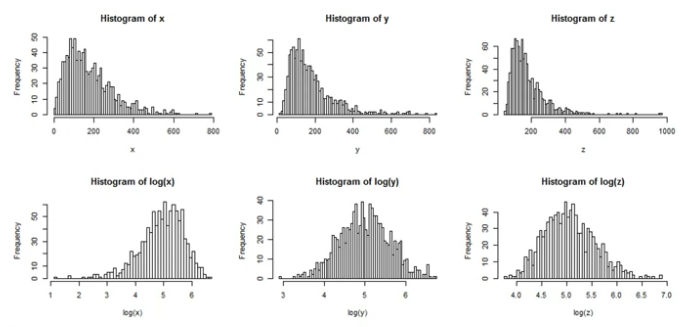

### IQR(Inter Quantile Range)를 이용한 Outlier Removal<br>
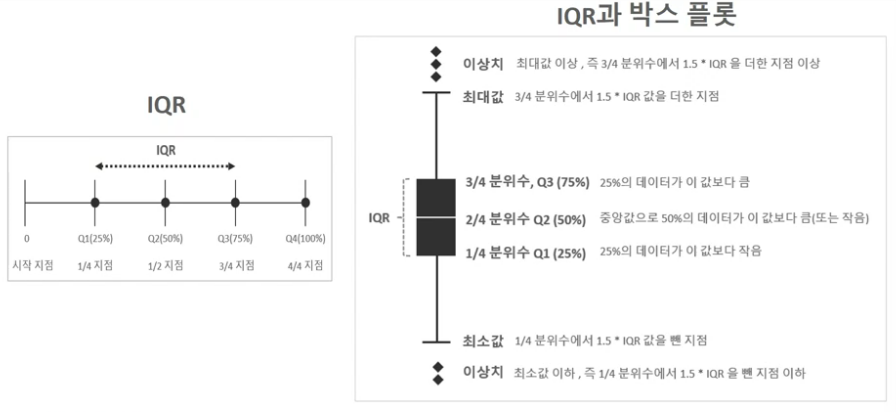

### 언더 샘플링(Under Sampling)과 오버 샘플링(Oversampling)<br>
* 레이블이 불균형한 분포를 가진 데이터 세트를 학습 시, 이상 레이블을 가지는 데이터 건수가 매우 적어 제대로 된 유형의 학습이 어려움
* 반면에 정상 레이블을 가지는 데이터 건수는 매우 많아 일방적으로 정상 레이블로 치우친 학습을 수행하여, 제대로 된 이상 데이터 검출이 어려움
* 대표적으로 오버 샘플링(Over Sampling)과 언더 샘플링(Under Sampling) 방법을 통해 적절한 학습 데이터를 확보함<br>
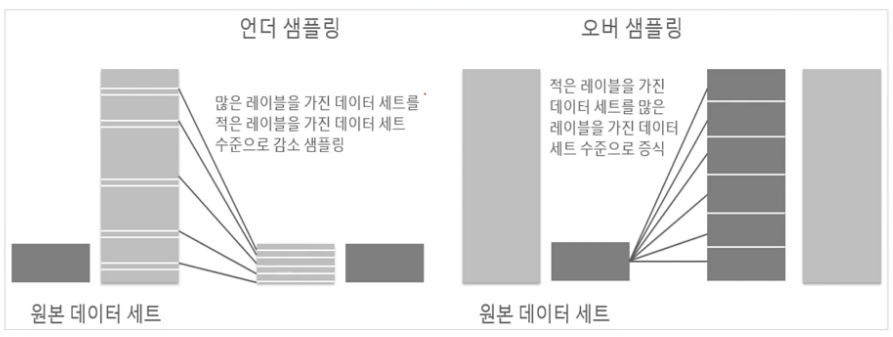<br>
=> 즉, 언더 샘플링은 정상 데이터를 샘플링해서 사기 데이터의 수만큼 감소<br>
=> 오버 샘플링은 사기 데이터를 증식해서 정상 데이터 수만큼 증가

### SMOTE(Synthetic Minority Over-Sampling Technique) 개요
* 회색 데이터가 사기 데이터, 푸른색 데이터가 정상 데이터<br>
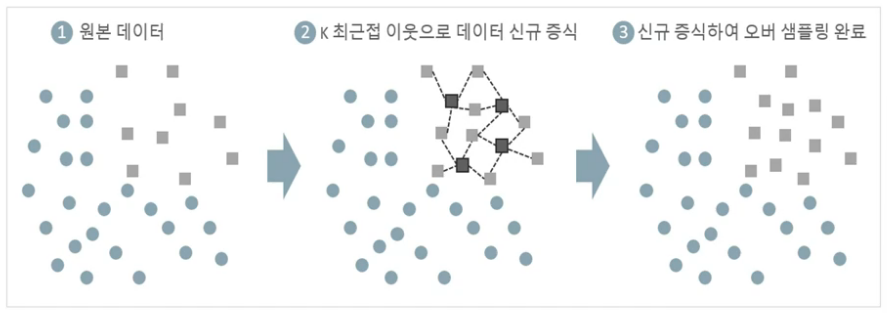

### 데이터 일차 가공 및 모델 학습/예측/평가
* 데이터 로드

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


=> amount는 쓴 금액을 의미하고, class = 0은 정상, class = 1은 사기를 의미

In [11]:
card_df.shape

(284807, 31)

* 원본 DataFrame은 유지하고 데이터 가공을 위한 DataFrame을 복사하여 반환

In [12]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

* 학습과 테스트 데이터 세트를 반환하는 함수 생성. 사전 데이터 처리가 끝난 뒤 해당 함수 호출

In [13]:
# 사전 데이터 가공 후 학습과 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나미저는 피처
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split()으로 학습과 테스트 데이터 분할. stratify = y_target으로 stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size = 0.3, random_state = 0,
                                                        stratify = y_target) # 워낙 imbalanced하기 때문에 꼭 적어주기
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [14]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0] * 100)
print()
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64

테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC_AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC_AUC print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [16]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 1000) # 최적화될 수 있는 iteration를 1000번까지 수행할 수 있도록 함
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85280    15]
 [   55    93]]
정확도 : 0.9992, 정밀도 : 0.8611, 재현율 : 0.6284,     F1 : 0.7266, AUC : 0.9698


=> 재현율이 상당히 중요. 실제로 사기인 거래를 사기라고 정확하게 예측하는 것이 중요하기 때문<br>
=> 따라서, 재현율을 높이는 것이 목표

* 앞으로 피처 엔지니어링을 수행할 때마다 모델을 학습/예측/평가하므로 이를 위한 함수 생성

In [17]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None): # 학습용 피처, 테스트용 피처, 학습용 라벨, 테스트용 라벨 순
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

### LightGBM 학습/예측/평가

* LightGBM 2.1.0 이상 버전에서 boost_from_average가 True가 Default가 됨. boost_from_average가 True일 경우 레이블 값이 극도로 불균형 분포를 이루면 재현율 및 ROC-AUC 성능이 매우 저하됨. 따라서 레이블 값이 극도로 불균형할 경우 boost_from_average를 False로 설정하는 것이 유리
* 일반적인 경우에는 boost_from_average = True의 성능이 조금 더 나음

In [18]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995, 정밀도 : 0.9573, 재현율 : 0.7568,     F1 : 0.8453, AUC : 0.9790


=> 로지스틱 회귀 모델보다 성능이 향상된 것을 확인할 수 있음<br>
=> 그래도 재현율을 더 높이기 위해 피처 엔지니어링을 추가로 수행해주도록 할 것임

### 데이터 분포도 변환 후 모델 학습/예측/평가

* 중요 feature 분포도 확인

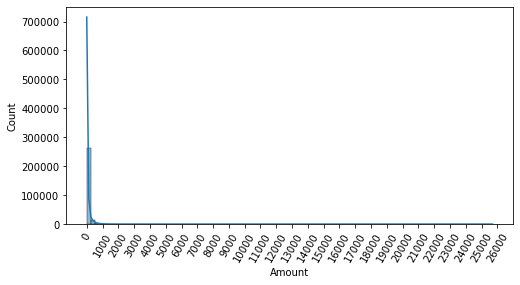

In [19]:
import seaborn as sns

plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.histplot(card_df['Amount'], bins = 100, kde = True)
plt.show()

* 데이터 변환 위해 StandardScaler와 log변환을 두 가지 방법을 사용<br><br>

* 1. 데이터 사전 가공을 위한 별도의 함수에 StandardScaler를 이용하여 Amount 피처 변환

In [20]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

* StandardScaler 변환 후 로지스틱 회귀 및 LightGBM 학습/예측/평가

In [21]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter = 1000)
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\n### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 : 0.9992, 정밀도 : 0.8654, 재현율 : 0.6081,     F1 : 0.7143, AUC : 0.9702

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도 : 0.9995, 정밀도 : 0.9569, 재현율 : 0.7500,     F1 : 0.8409, AUC : 0.9779


* 2. Amount를 로그 변환

In [22]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [23]:
# log1p와 expm1의 설명
import numpy as np

print(1e-1000 == 0.0) # 너무 작은 값은 0으로 표시함

print(np.log(1e-1000))

print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


In [24]:
var_1 = np.log1p(100) # log1p는 1을 더해주고 로그 변환
var_2 = np.expm1(var_1) # 다시 원상복구해주는 함수인 expm1
print(var_1, var_2)

4.61512051684126 100.00000000000003


In [25]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도 : 0.9992, 정밀도 : 0.8812, 재현율 : 0.6014,     F1 : 0.7149, AUC : 0.9727

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도 : 0.9995, 정밀도 : 0.9576, 재현율 : 0.7635,     F1 : 0.8496, AUC : 0.9796


=> StandardScaler보다 log 변환이 조금 더 성능 향상을 보이는 것을 알 수 있음

* 로그 변환한 Amount 변수 분포 확인

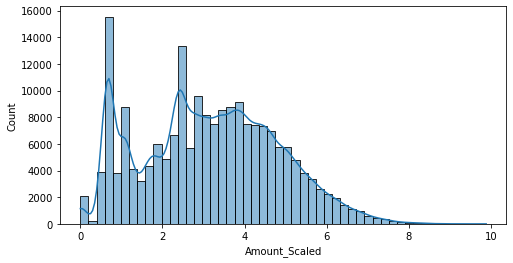

In [26]:
import seaborn as sns

plt.figure(figsize = (8, 4))
sns.histplot(X_train['Amount_Scaled'], bins = 50, kde = True)
plt.show()

=> 완벽한 정규분포의 형태는 아니지만 skew가 굉장히 줄어든 것을 확인할 수 있음

### 이상치 데이터 제거 후 모델 학습/예측/평가

* 각 피처들의 상관 관계를 시각화. 결정 레이블인 class 값과 가장 상관도가 높은 피처 추출

<AxesSubplot:>

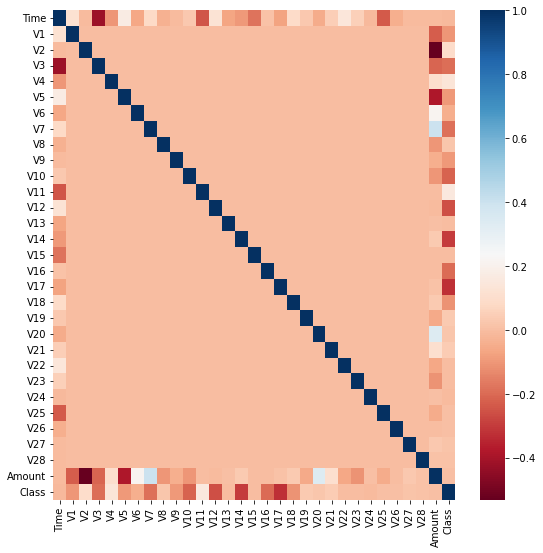

In [27]:
import seaborn as sns

plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

=> class 열과 V14열의 상관도가 높기 때문에 V14열의 이상치를 찾아봄

* DataFrame에서 outlier에 해당하는 데이터를 필터링하기 위한 함수 생성. outlier 레코드의 index를 반환함

In [28]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
    # fraud에 해당하는 column 데이터만 추출. 1/4분위와 3/4분위 지점을 np.percentile로 구함
    fraud = df[df['Class'] == 1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함
    Iqr = quantile_75 - quantile_25
    Iqr_weight = Iqr * weight
    lowest_val = quantile_25 - Iqr_weight
    highest_val = quantile_75 + Iqr_weight
    # 최대값보다 크거나 최소값보다 작은 값을 outlier로 설정하고 DataFrame index 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [29]:
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스 :', outlier_index)

이상치 데이터 인덱스 : Int64Index([8296, 8615, 9035, 9252], dtype='int64')


* 로그 변환 후 V14 피처의 이상치 데이터를 삭제한 뒤 모델들을 재학습/예측/평가

In [30]:
# get_preprocessed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True) # 행에 대해 drop을 하기 때문에 axis = 0으로 설정
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)
print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993, 정밀도 : 0.8750, 재현율 : 0.6712,     F1 : 0.7597, AUC : 0.9743

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996, 정밀도 : 0.9603, 재현율 : 0.8288,     F1 : 0.8897, AUC : 0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [31]:
import imblearn

print(imblearn.__version__)

0.9.1


In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 :\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 :
 0    199020
1    199020
Name: Class, dtype: int64


=> SMOTE 적용 후 행의 개수가 늘었음<br>
=> 정상 데이터에 맞춰 사기 데이터의 갯수가 늘었기 때문<br>
=> validation, test 데이터는 oversampling하면 안됨

In [34]:
lr_clf = LogisticRegression(max_iter = 1000)

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723, 정밀도 : 0.0542, 재현율 : 0.9247,     F1 : 0.1023, AUC : 0.9737


=> 재현율이 눈에 띄게 상승했으나 정밀도가 너무 떨어짐

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize = (8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold값 X축의 scale을 0, 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

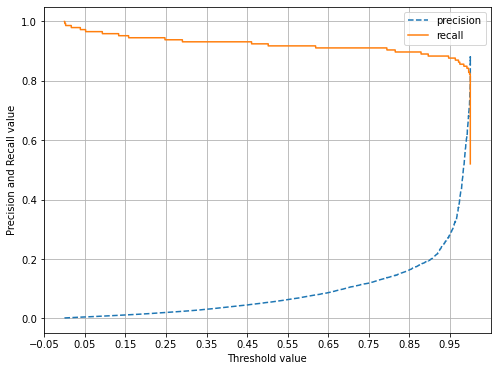

In [36]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

=> 재현율은 엄청 높지만, 정밀도가 거의 올라오지 않고 낮은 수준에만 머물러 있음

In [38]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test,
                     tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996, 정밀도 : 0.9118, 재현율 : 0.8493,     F1 : 0.8794, AUC : 0.9814


=> SMOTE 하기 전의 결과와 비교했을 때 재현율은 조금 오르고, 정밀도는 더 많이 떨어짐<br>
=> 재현율이 현재 상황에서 조금 더 중요하기 때문에 정밀도를 희생해서라도 재현율을 높이는 것이 중요

# 11. 스태킹 앙상블

* 기반 모델들이 예측한 값들을 stacking 형태로 만들어서 메타 모델이 이를 학습하고 예측하는 모델<br>
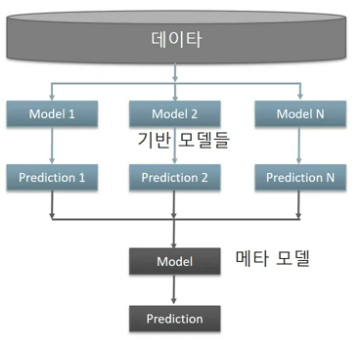<br>
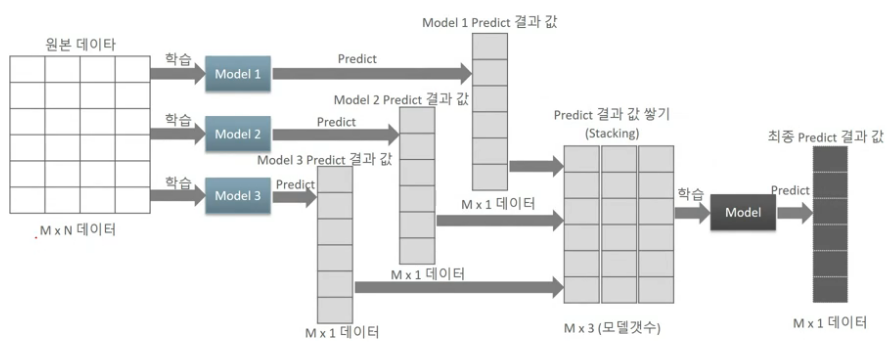<br>

### 기본 스태킹 모델

* 데이터 로딩

In [39]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label,
                                                   test_size = 0.2, random_state = 0)

* 개별 Classifier와 최종 Stacking 데이터를 학습할 메타 Classifier 생성

In [40]:
# 개별 ML 모델을 위한 Classifier 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

# 최종 Stacking 모델을 위한 Classifier 생성
lr_final = LogisticRegression(C = 10)

* 개별 Classifier 학습/예측/평가

In [41]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [42]:
# 개별 모델들이 각자 반환하는 예측 데이터셋을 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도 : {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도 : 0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9035
에이다부스트 정확도 : 0.9561


* 개별 모델의 예측 결과를 메타 모델이 학습할 수 있도록 스태킹 형태로 재생성

In [46]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


* 메타 모델 학습/예측/평가

In [47]:
lr_final.fit(pred, y_test) # test 데이터를 이용해서 학습을 하기 때문에 오버피팅 발생
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도 : 0.9649


### CV 세트 기반의 스태킹
* 교차 검증 세트 기반의 스태킹은 이에 대한 개선을 위해 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행한다. 이는 다음과 같이 2단계의 스텝으로 구분될 수 있다.
 * 스텝 1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성한다.
 * 스텝 2 : 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성한다. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 데이터 세트를 생성한다. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가한다.

1. 교차 검증 세트 기반 스태킹 모델 만들기 - K Fold 첫 번째<br>
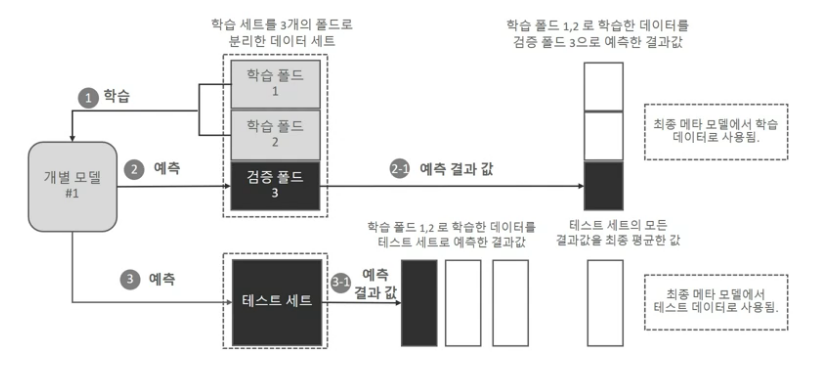<br>

2. 교차 검증 세트 기반 스태킹 모델 만들기 - K Fold 두번째<br>
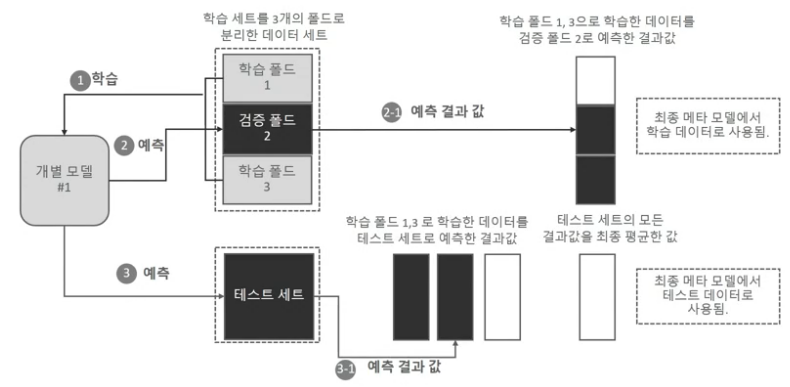

3. 교차 검증 세트 기반 스태킹 모델 만들기 - K Fold 세번째<br>
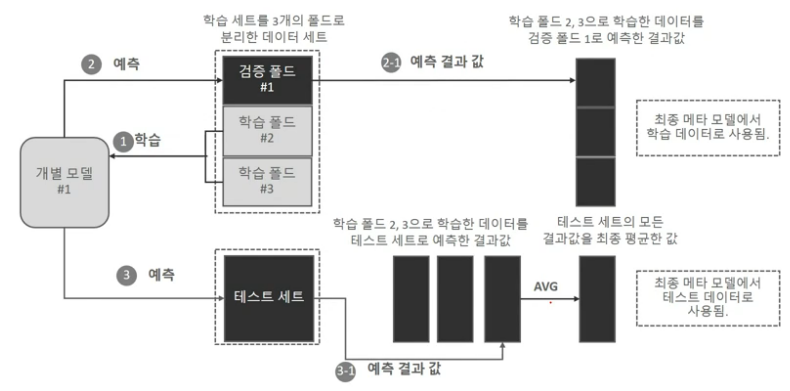

4. 교차 검증 세트 기반 스태킹 모델 만들기 - 최종<br>
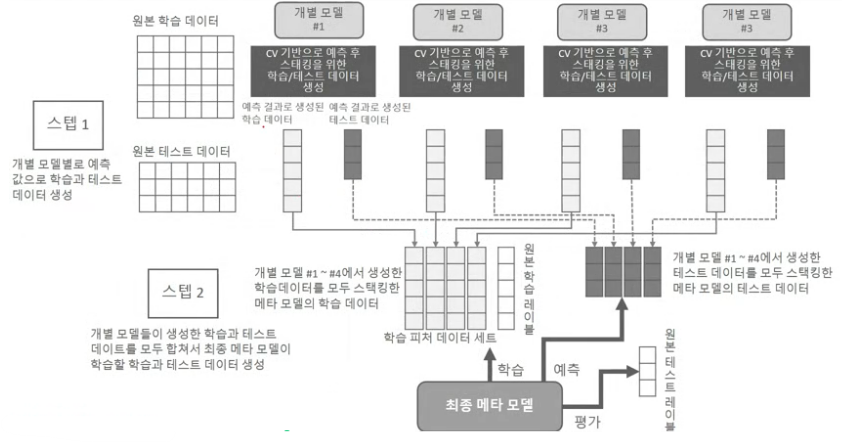

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = False)
    
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트 :', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

=> 개별 모델들이 반환하는 값이라는 점을 명심

In [55]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
RandomForestClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
AdaBoostClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작


In [56]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis = 1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis = 1)
print('원본 학습 데이터 피처 Shape :', X_train.shape, '원본 데스트 피처 Shape :', X_test.shape)
print('스태킹 학습 피처 데이터 Shape :', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape :', Stack_final_X_test.shape)

원본 학습 데이터 피처 Shape : (455, 30) 원본 데스트 피처 Shape : (114, 30)
스태킹 학습 피처 데이터 Shape : (455, 4) 스태킹 테스트 피처 데이터 Shape : (114, 4)


In [57]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도 : 0.9737


# 12. 정리
* 결정 트리와 결정 트리 기반의 앙상블
* 배깅과 부스팅
 * 랜덤 포레스트, GBM
* GBM의 기능을 더욱 향상시킨 XGBoost, LightGBM
* 스태킹 모델